# An introduction to the SpecOneD class
In this notebook we will demonstrate the functionality of the SpecOneD class, the 1-D class for astronomical spectra introduced in the **SpecOneD** package. SpecOneD objects are designed to hold the spectral information of an astronomical source along with ancillary information, such as the data header generated by the observatory or the reduction software or the physical units of the dispersion and flux density axis.

## Introducing the SpecOneD object
We begin by introducing the SpecOneD object and its attributes. As a first step we import the SpecOneD module from speconed and generate an emptye SpecOneD object. 

In [1]:
# Import the speconed module from speconed
from speconed import speconed as sod

# Instantiate an empty SpecOneD object
spec = sod.SpecOneD()

We have now instantiated an empty SpecOneD object called *spec*. Let's take a quick look at the class attributes by iterating over them.

In [2]:
for key in vars(spec).keys():
    print(f'{key}')

fluxden
fluxden_err
dispersion
fluxden_ivar
mask
dispersion_unit
fluxden_unit
header
fits_header
obj_model
telluric


Every SpecOneD object will be instantiated with a range of numpy.ndarrays holding information on the dispersion axis (dispersion), the flux density (fluxden), the flux density error (fluxden_err), a mask (mask). All of these arrays have to have the same length. 

In addition, the two attributes "dispersion_unit" and "fluxden_unit" contain the information on the physical units of the dispersion axis as well as the flux density (and flux density error). These attributes are populated with astropy.units.Quantity (astropy.units.Unit, astropy.units.CompositeUnit, astropy.units.IrreducibleUnit) enabling to use the astropy.units module for unit conversion. This is also an important aspect for the analysis of the spectral models later on.

The "header" attribute is a pandas.DataFrame with additional information of the spectrum. If the header was populated through a fits file the original fits header is available at the "fits_header" attribute. Note that when initializing a SpecOneD object you should pass your fits header under the *header* keyword.

Spectra reduced by *PypeIt* and read in from the *PypeIt* fits format might carry additional information about the object_model and the telluric model from the telluric correction, which will be saved in the "obj_model" and "telluric" attributes. 

## Manual initialization of a SpecOneD object
While the SpecOneD class offers functionality to import spectra from iraf or PypeIt standard data reductions and also supports the SDSS format, it is important to know how to initialize spectra manually for custom use. For this example we use the SDSS spectrum of the quasar J030341.04-002321.8 available in the speconed data folder.  

In [3]:
# Let's begin by importing astropy fits and units functionality
from astropy.io import fits
import astropy.units as units

# Define the name of the example spectrum
spec_filename = '../../speconed/data/example_spectra/J030341.04-002321.8_0.fits'

# Read in the example spectrum with astropy
hdu = fits.open(spec_filename)

# Extract the dispersion axis, the flux density and the error from the fits file
dispersion = hdu[1].data['loglam']
flux_density = hdu[1].data['flux']
flux_density_ivar = hdu[1].data['ivar']

# Extract the fits header of the spectrum 
header = hdu[0].header

# Before we initialize the SpecOneD object we need to convert the dispersion axis to a linear scale
dispersion = 10**dispersion

# The header provides information on the units of the spectrum (Let's print it out below!)
print('Wavelength unit: {}'.format(header['WAT1_001']))
print('Flux density unit: {}'.format(header['BUNIT']))

dispersion_unit = 1.*units.AA
fluxden_unit = 1e-17 * units.erg/units.s/units.cm**2/units.AA

# Now we can initialize a SpecOneD object manually
spec = sod.SpecOneD(dispersion=dispersion, fluxden=flux_density, fluxden_ivar=flux_density_ivar,
                   fluxden_unit=fluxden_unit, dispersion_unit=dispersion_unit, header=header)

Wavelength unit: wtype=linear label=Wavelength units=Angstroms
Flux density unit: 1E-17 erg/cm^2/s/Ang


**We have done it! We have manually initialized a SpecOneD object**

Let us now take a closer look if everything worked. We begin by checking the types and shapes of the main SpecOneD attributes: *flux density*, *dispersion*, *mask*, *flux density error*, the units and the header

In [4]:
print('Flux density -  type {}, size {} \n'.format(type(spec.fluxden), spec.fluxden.shape))
print('Dispersion axis -  type {}, size {} \n'.format(type(spec.dispersion), spec.dispersion.shape))
print('Flux density error -  type {}, size {} \n'.format(type(spec.fluxden_err), spec.fluxden_err.shape))
print('Mask -  type {}, size {} \n'.format(type(spec.mask), spec.mask.shape))

print('Dispersion unit -  value {} and type {} \n'.format(spec.dispersion_unit, type(spec.dispersion_unit)))
print('Flux density unit - value {} and type {} \n'.format(spec.fluxden_unit, type(spec.fluxden_unit)))

print('Header DataFrame \n', spec.header)

Flux density -  type <class 'numpy.ndarray'>, size (3614,) 

Dispersion axis -  type <class 'numpy.ndarray'>, size (3614,) 

Flux density error -  type <class 'numpy.ndarray'>, size (3614,) 

Mask -  type <class 'numpy.ndarray'>, size (3614,) 

Dispersion unit -  value 1.0 Angstrom and type <class 'astropy.units.quantity.Quantity'> 

Flux density unit - value 1e-17 erg / (Angstrom cm2 s) and type <class 'astropy.units.quantity.Quantity'> 

Header DataFrame 
                                  value
SIMPLE                            True
BITPIX                               8
NAXIS                                0
EXTEND                            True
TAI                      4477028053.74
...                                ...
EXPID02  b1-00006799-00006802-00006803
EXPID03  b1-00006800-00006802-00006803
EXPID04  r1-00006798-00006802-00006803
EXPID05  r1-00006799-00006802-00006803
EXPID06  r1-00006800-00006802-00006803

[138 rows x 1 columns]


Everything seems to look reasonable here. However, a visual inspection of the spectrum will be necessary to convince us that it was read in correctly. For this purpose the SpecOneD class offers a simple plot functionality:

## Using .plot() for quick visualization of the spectrum

The spectrum can be plotted with the built-in plot functionality, which uses matplotlib. Note that the units in the axis labels will be automatically populated by the units from the SpecOneD object (spec.dispersion_unit, spec.fluxden_unit).

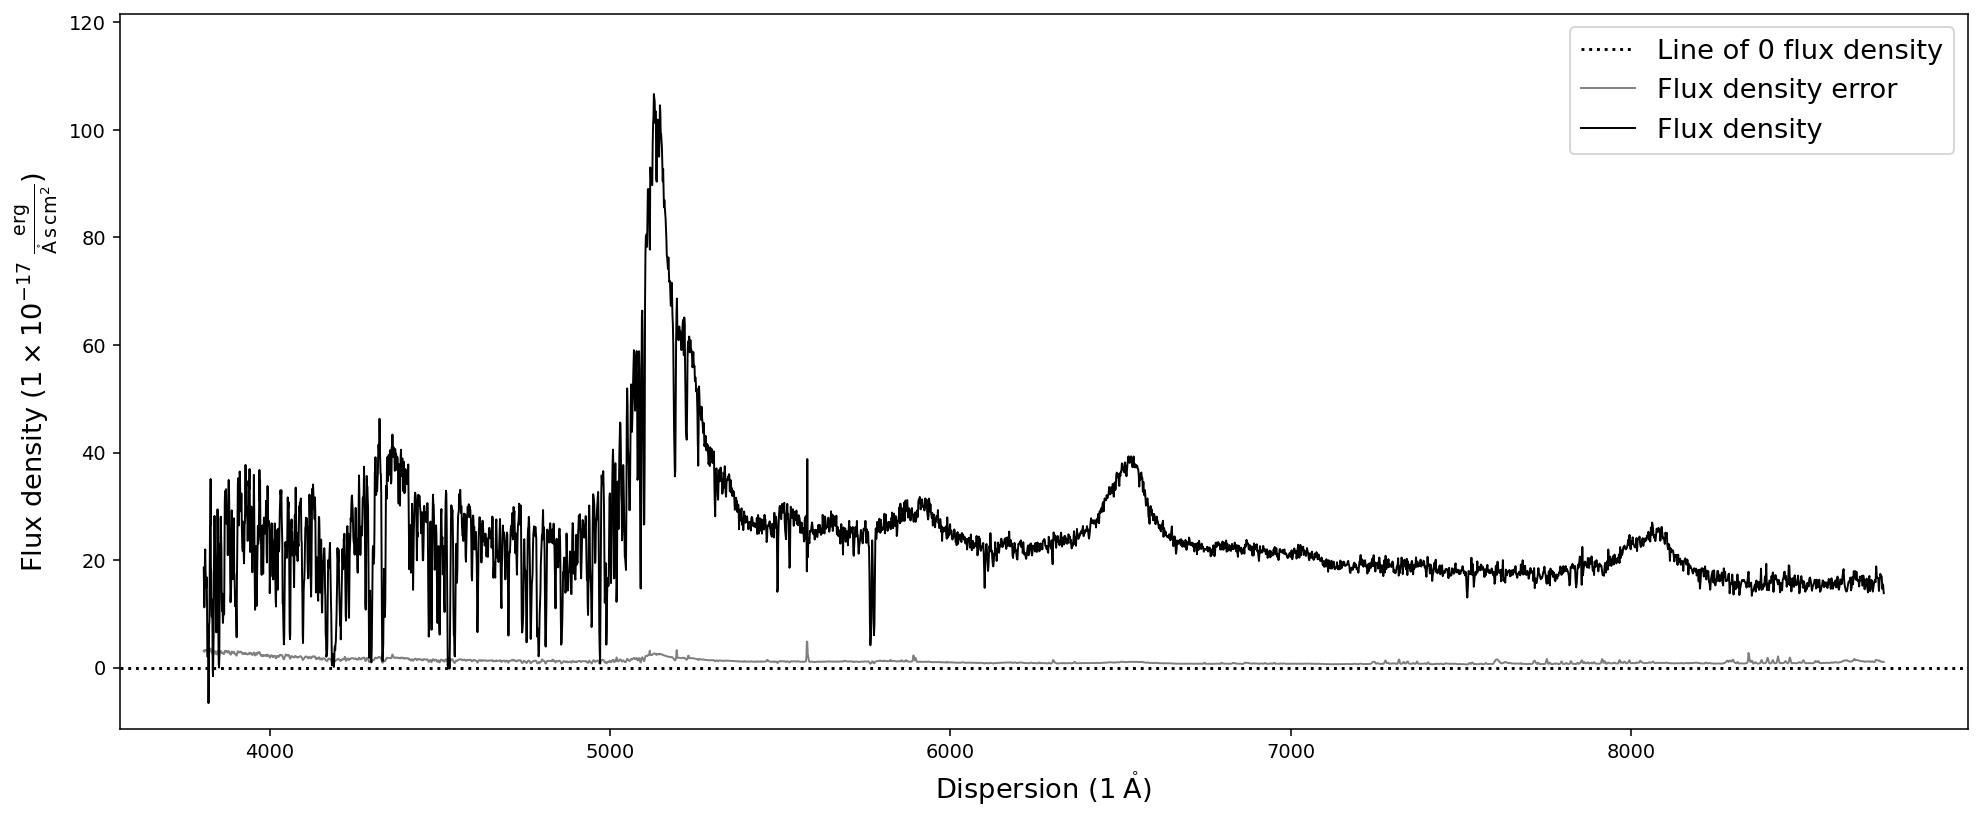

In [5]:
spec.plot()

We expect the source to be a quasar at redshift z=3.227. Therefore we expect the Lyman-alpha emission line around 5140A. A look at the plot convinces us that the spectrum was read in correctly, including the axis units.

## Saving and reading in SpecOneD objects
SpecOneD allows to save spectra to the *hdf* format, which is the *native* way to save spectra within the SpecOneD class. The spectral data, meta data and the header will be saved in a file.

In [6]:
# Saving the SpecOneD spectrum in its native format
spec.save_to_hdf('temp_spectrum.hdf5')

/opt/miniconda3/envs/speconed/lib/python3.10/site-packages/speconed/speconed.py:419: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['value'], dtype='object')]

  self.header.to_hdf(filename, 'header')


In a similar fashion we can read in the spectrum again:

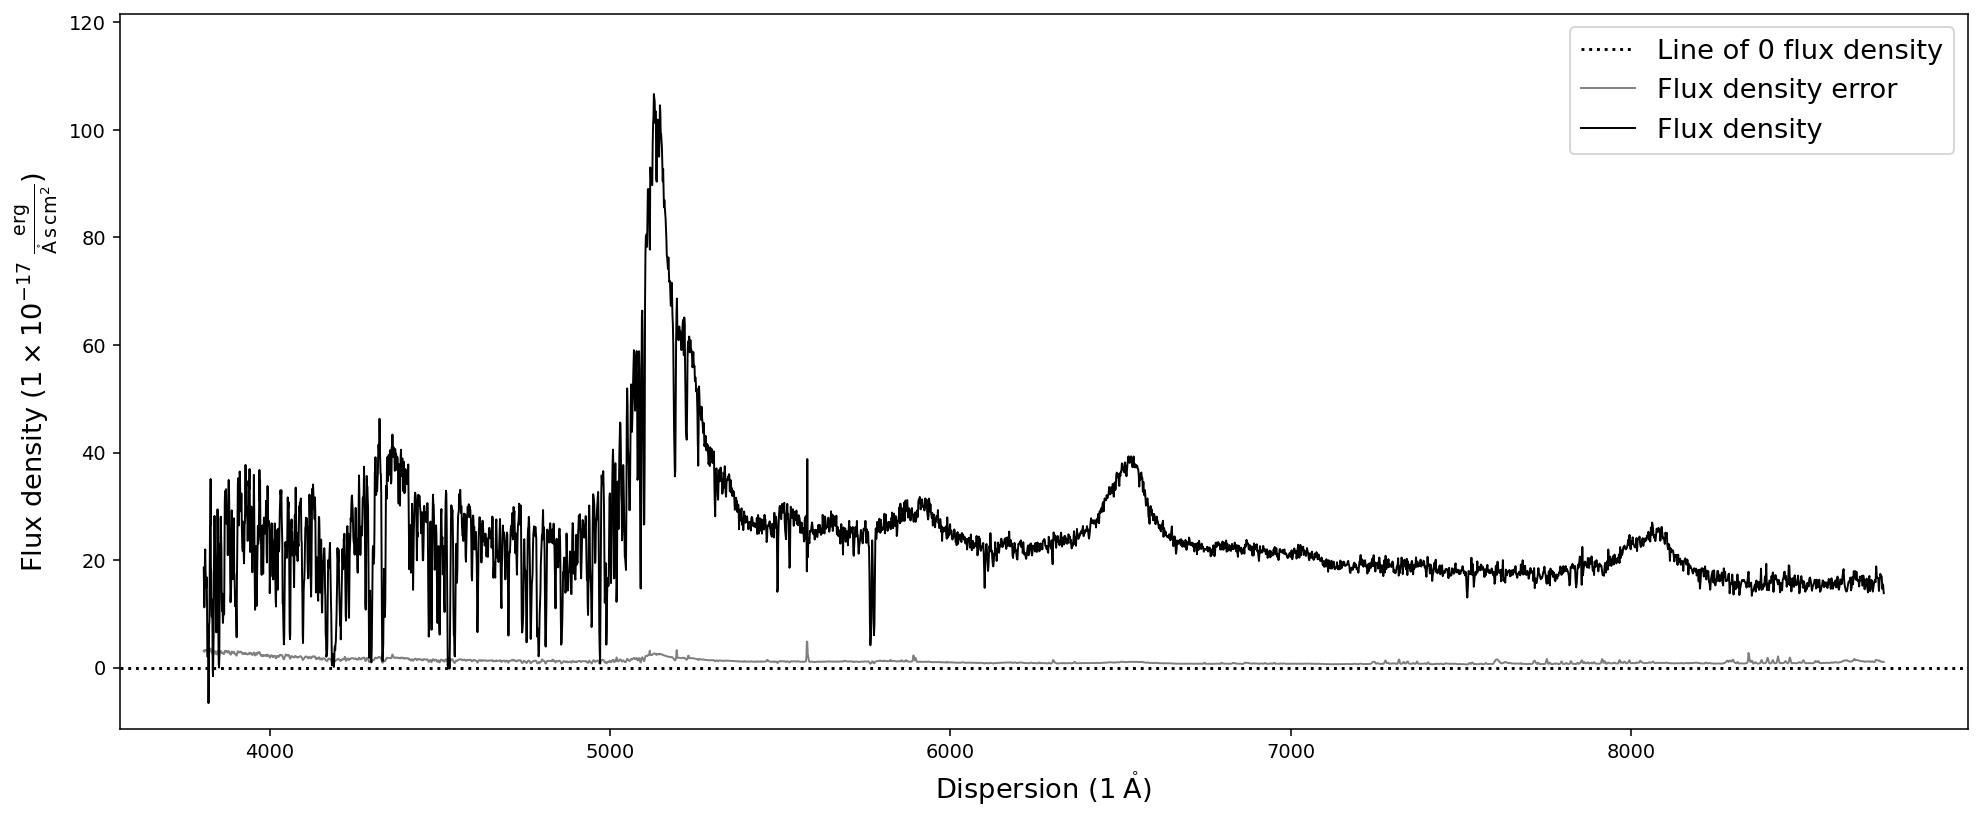

Flux density unit according to header is 1E-17 erg/cm^2/s/Ang
The fits header attribute is: None


In [7]:
# Before we read in a SpecOneD object, we need to initialize an empty object
new_spec = sod.SpecOneD()
# Then we use the read_from_hdf function and the filename
new_spec.read_from_hdf('temp_spectrum.hdf5')

# As a test we plot the spectrum
new_spec.plot()
# and test if the header was saved and read in correctly
print('Flux density unit according to header is {}'.format(new_spec.header.loc['BUNIT','value']))

# However, the fits header attribute is not populated
print('The fits header attribute is: {}'.format(new_spec.fits_header))

# To keep the notebook directoy clean we delete the temporary spectrum file 
! rm temp_spectrum.hdf5

Great! The spectrum was saved and read in correctly.

**Note: Because we did not initialize the new spectrum from a fits file the *fits_header* attribute is *None*.**

## Reading in spectra from other formats

In the current version of SpecOneD the speconed module has three implemented methods to read in spectra from
* an IRAF 1D fits file (in many cases the flux density and dispersion units need to be set manually)
* an PypeIT 1D fits file
* an SDSS fits file

These read function automizes the steps of the manual initialization above. We now go through quick examples:

We begin by readin in the SDSS quasar spectrum from before in only two lines:

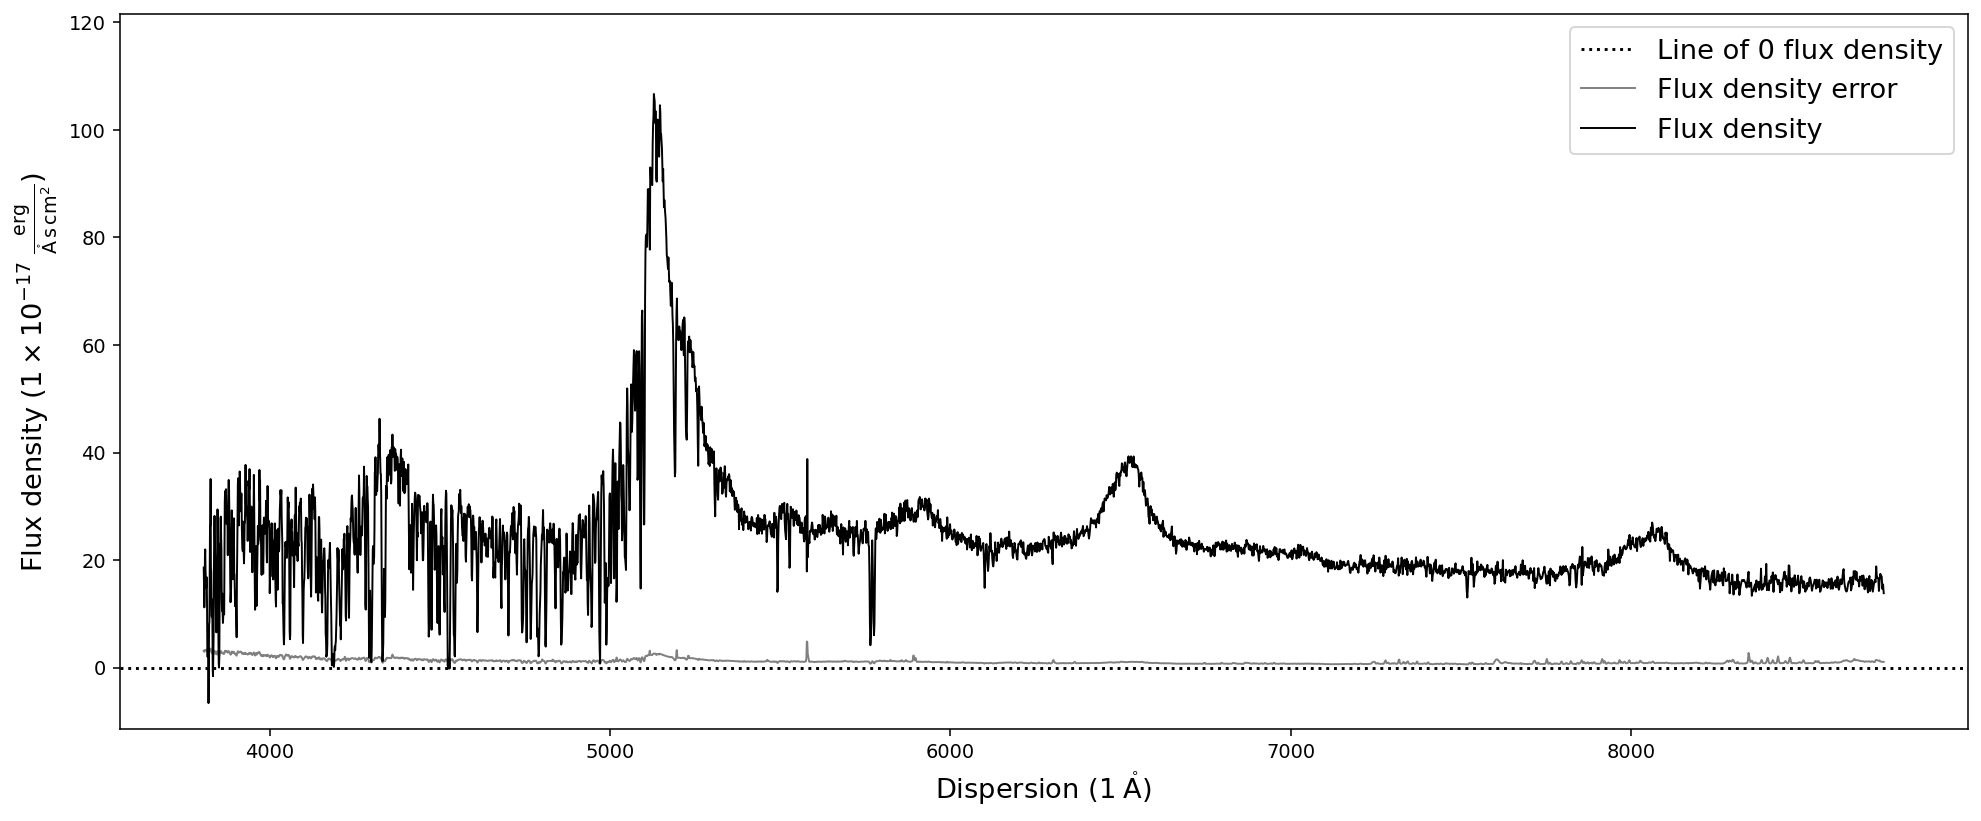

In [8]:
# Initializing an empty SpecOneD object
sdss_spec = sod.SpecOneD()
# Read in the spectrum using the SDSS read function
sdss_spec.read_sdss_fits('../../speconed/data/example_spectra/J030341.04-002321.8_0.fits')
# Plot the spectrum 
sdss_spec.plot()

The SpecOneD data directory also includes example (quasar) spectra in IRAF and PypeIT fits format. Reading them in as a SpecOneD object is just as simple as in the case of the SDSS spectrum.

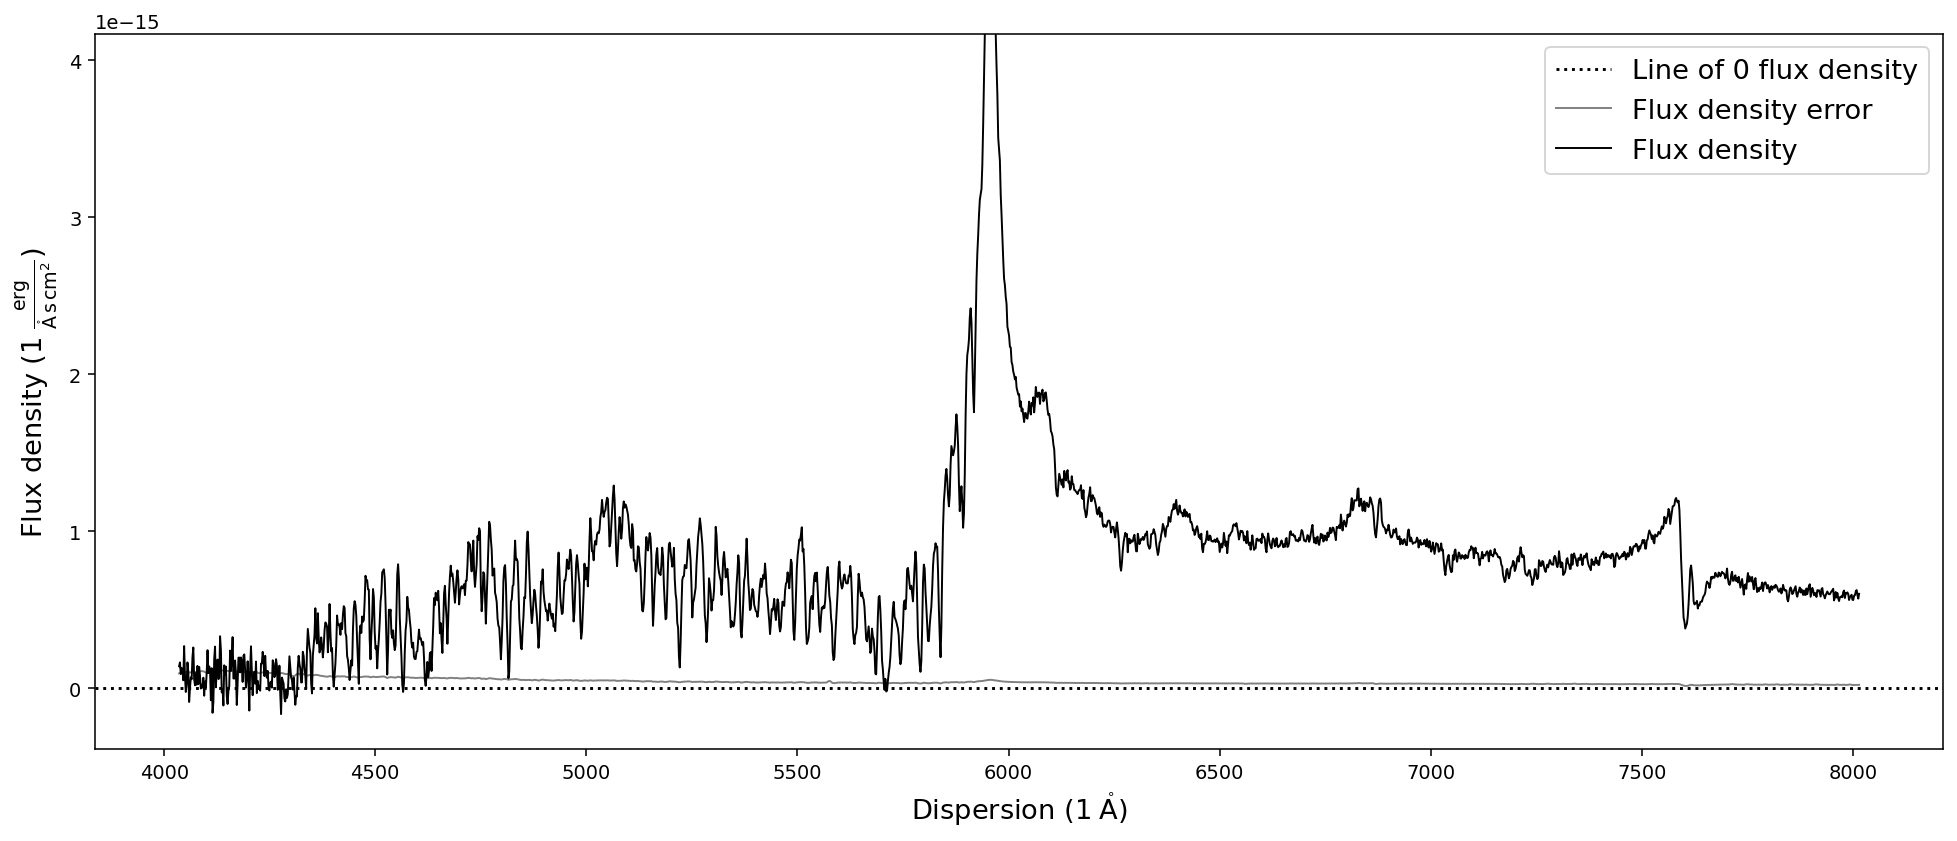

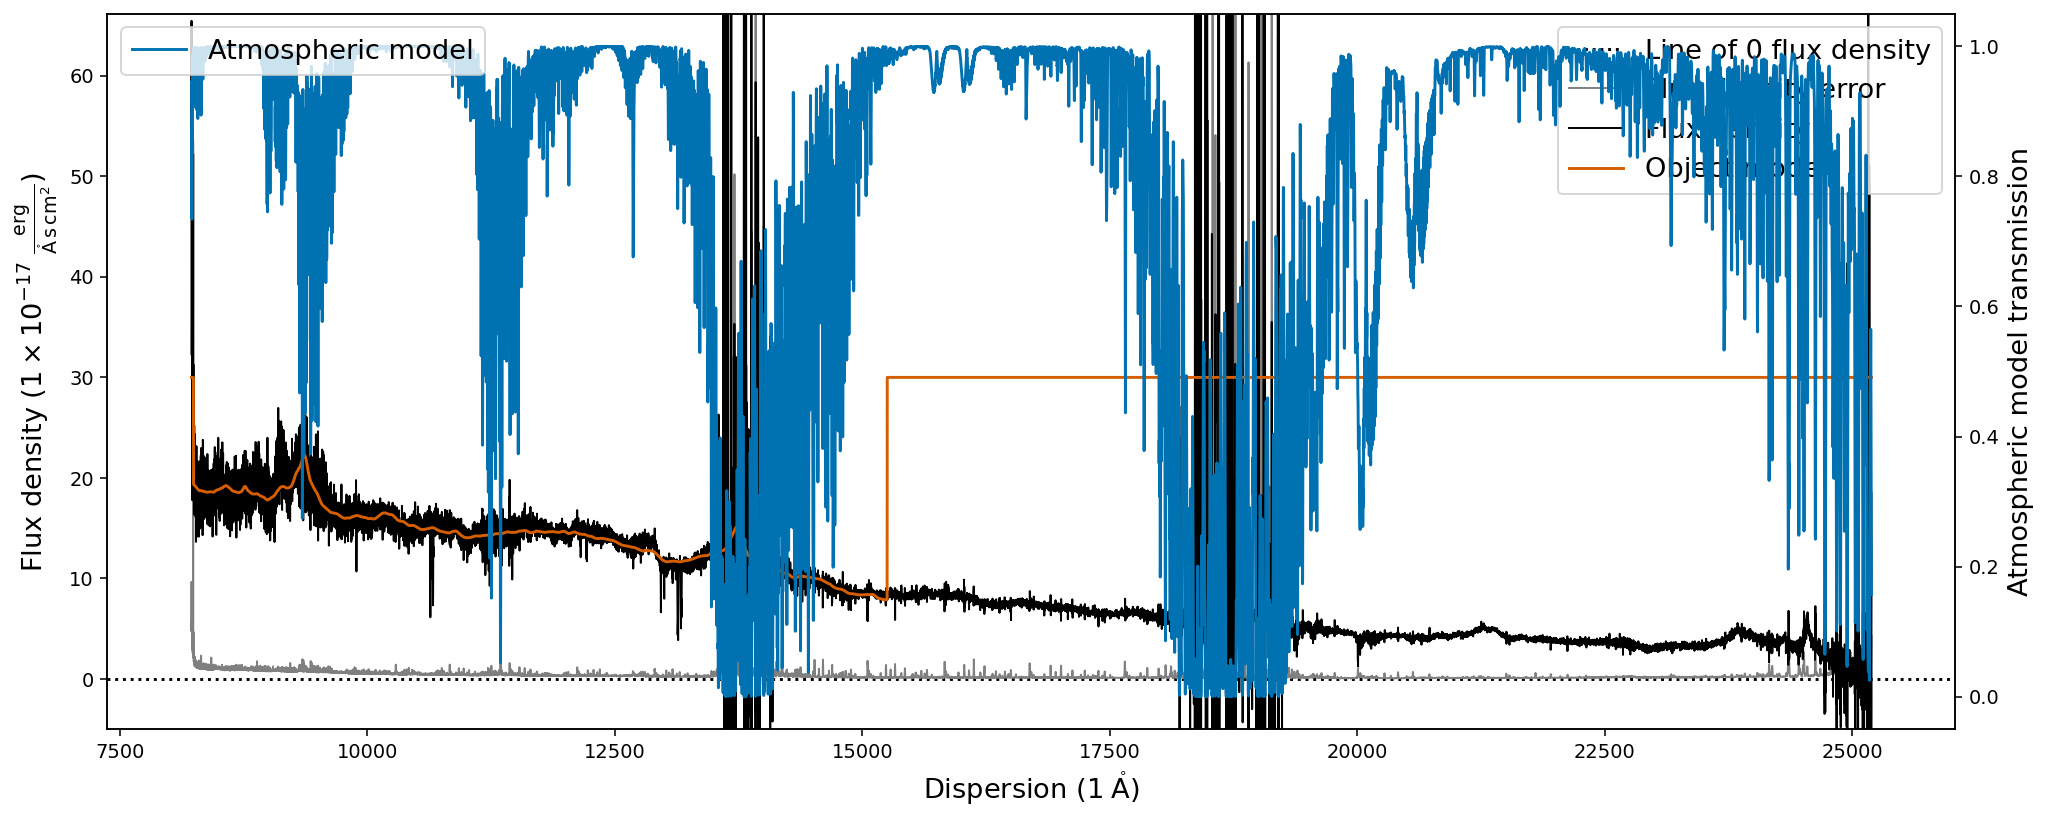

In [9]:
# Initializing an empty SpecOneD object 
iraf_spec = sod.SpecOneD()
# Read in the spectrum using the IRAF read function
iraf_spec.read_from_fits('../../speconed/data/example_spectra/J2125-1719_OPT_A.fits')
# Plot the spectrum 
iraf_spec.plot()

# Initializing an empty SpecOneD object
pypeit_spec = sod.SpecOneD()
# Read in the spectrum using the PypeIt read function
pypeit_spec.read_pypeit_fits('../../speconed/data/example_spectra/J2125-1719_NIR.fits')
# Plot the spectrum 
pypeit_spec.plot()

The first plot shows the optical spectrum of the ultra-luminous quasar J2125-1719, whereas the second shows the near-infrared spectrum. 

The second plot however does show additional information, the object model (orange) and the atmospheric transmission (blue) from the PypeIt telluric correction routines. It also shows that the default *.plot()* capabilities of the SpecOneD class are not appropriate for generating publication grade figures as the legends in the second plot are not well placed.

## Unit conversions

With the flux density and dispersion units included as astropy unit classes within the SpecOneD object, we have all the great unit conversion functionality of astropy.units at our disposal. We want to briefly demonstrate how this works. Let us begin again with our default SDSS quasar spectrum *sdss_spec*. The default units were 

In [10]:
print(sdss_spec.fluxden_unit)
print(sdss_spec.dispersion_unit)

1e-17 erg / (Angstrom cm2 s)
1.0 Angstrom


The function *convert_spectral_units* allows us to convert the spectral units by specifying the new dispersion and new flux density unit. 

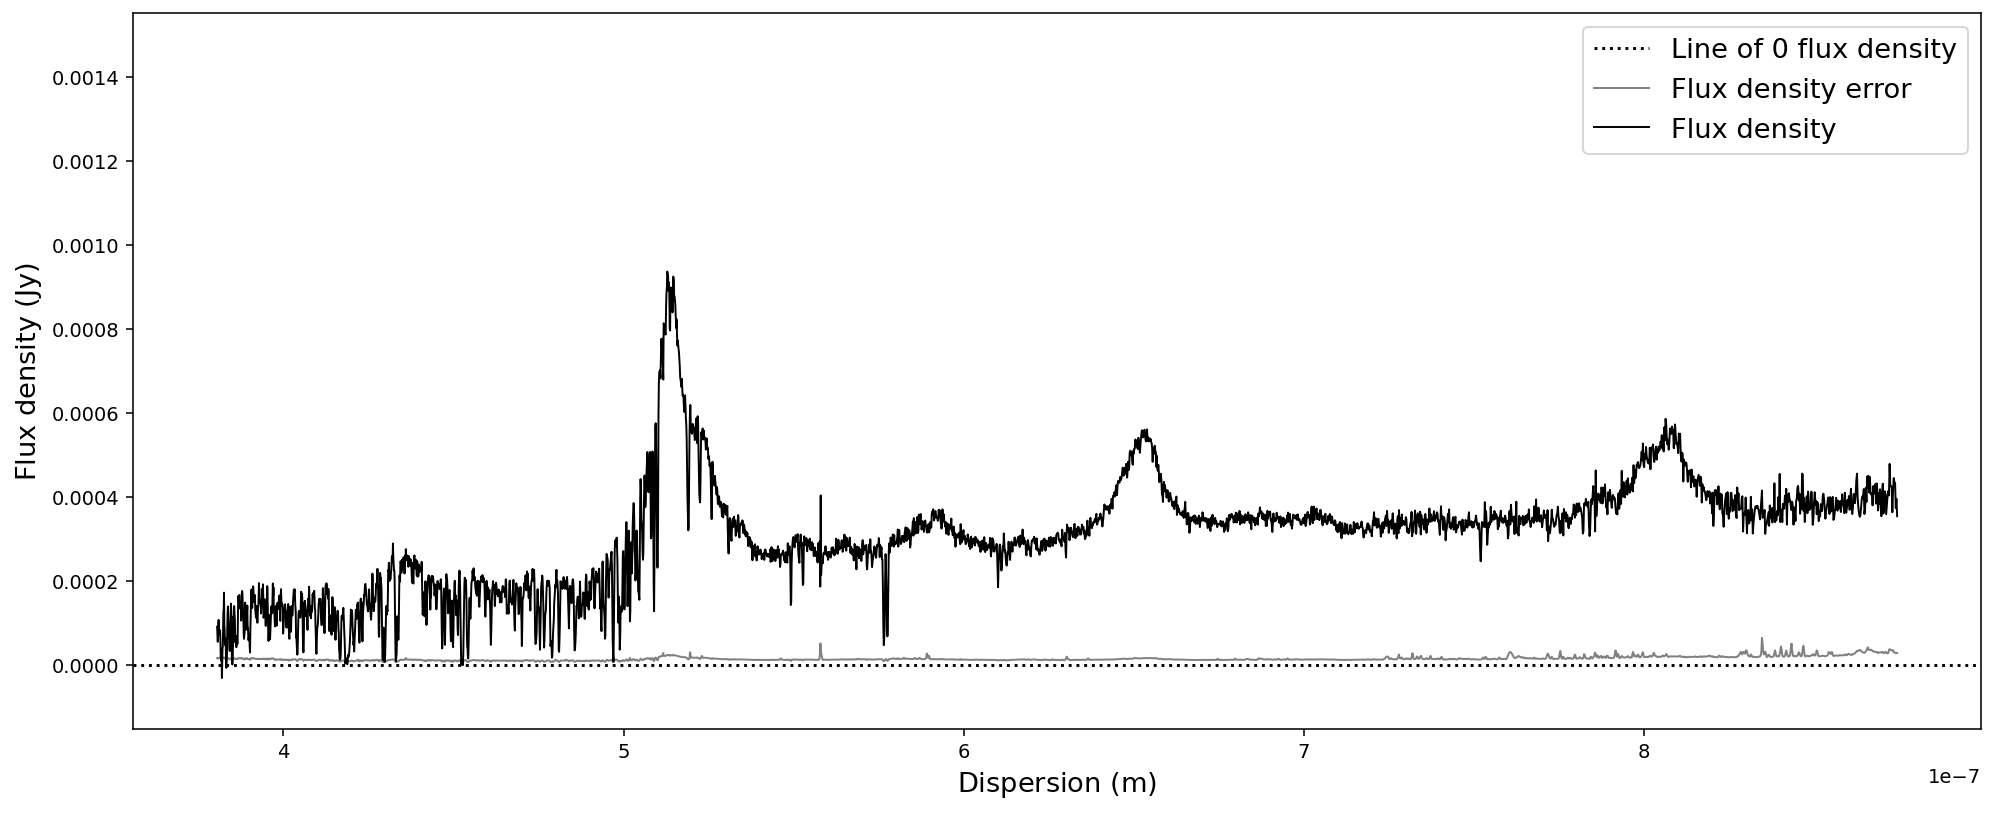

In [11]:
# Convert the dispersion to meters and the flux density to Jansky
sdss_spec.convert_spectral_units(1*units.m,1*units.Jy)
# Display the spectrum 
sdss_spec.plot()

As long as the new units are reasonable for a flux density and a dispersion axis, you will be able to convert the spectrum. Internally the conversion uses *spectral* and *spectral_density* equivalencies, which will lead to an error if one would choose units that do not obey these equivalencies. Please consult the [astropy documentation](https://docs.astropy.org/en/stable/units/equivalencies.html) for details.

For our case, the SpecOneD class comes with default conversion functions for common spectral units:

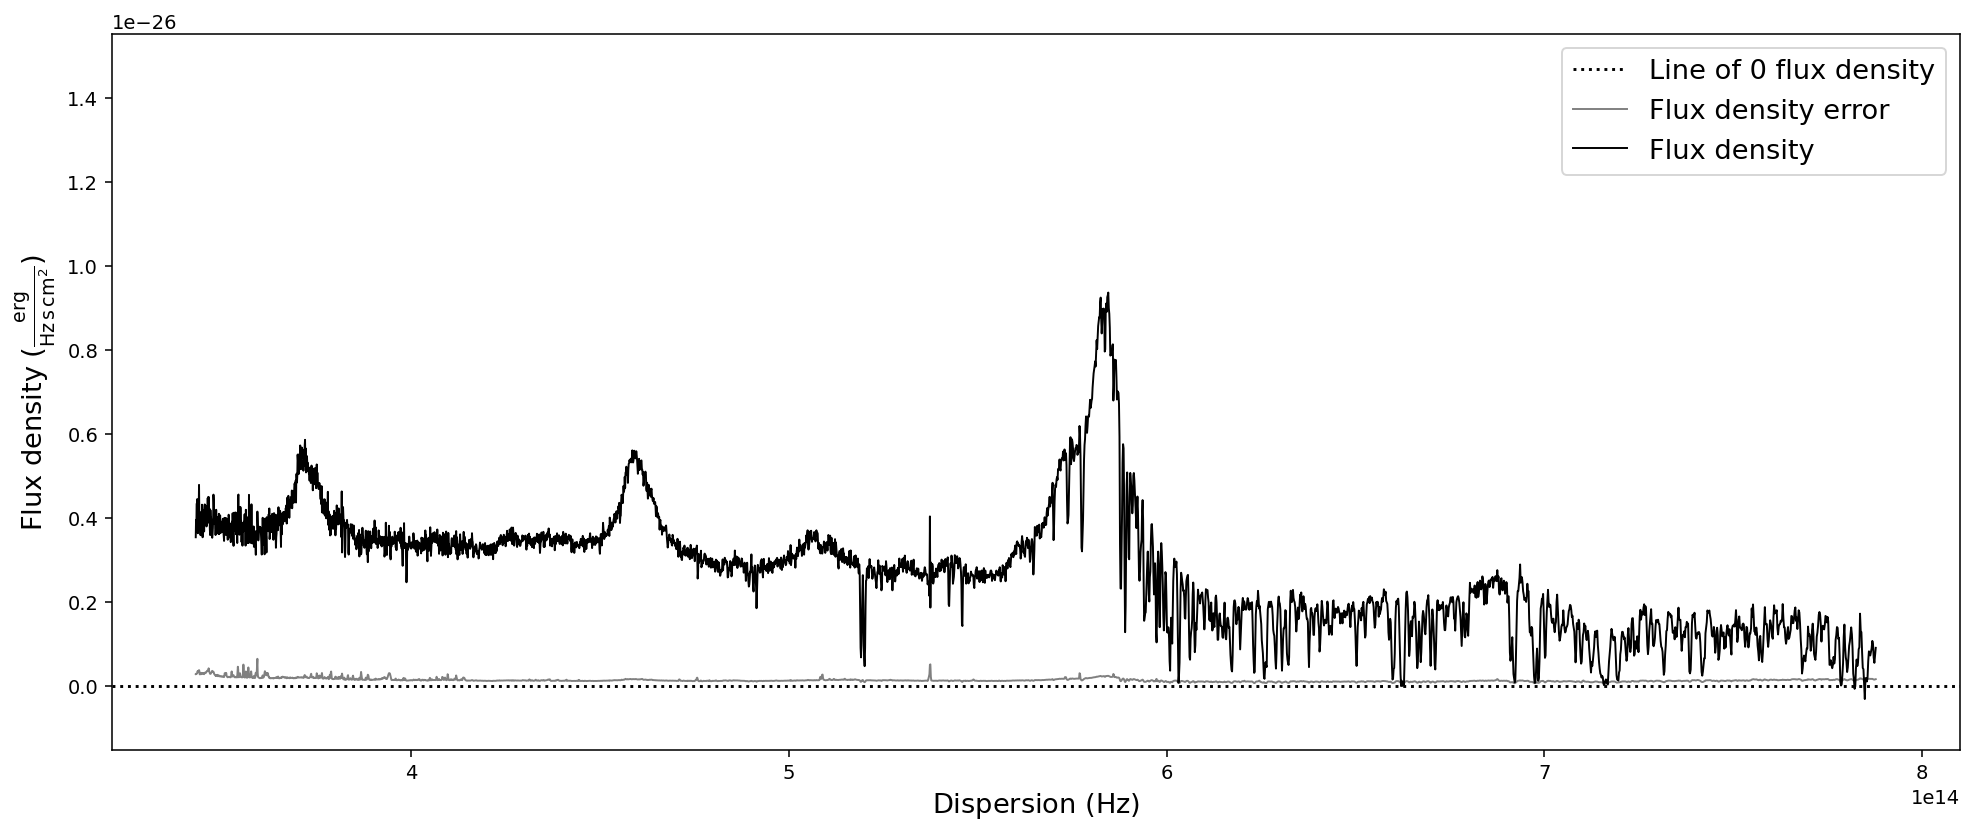

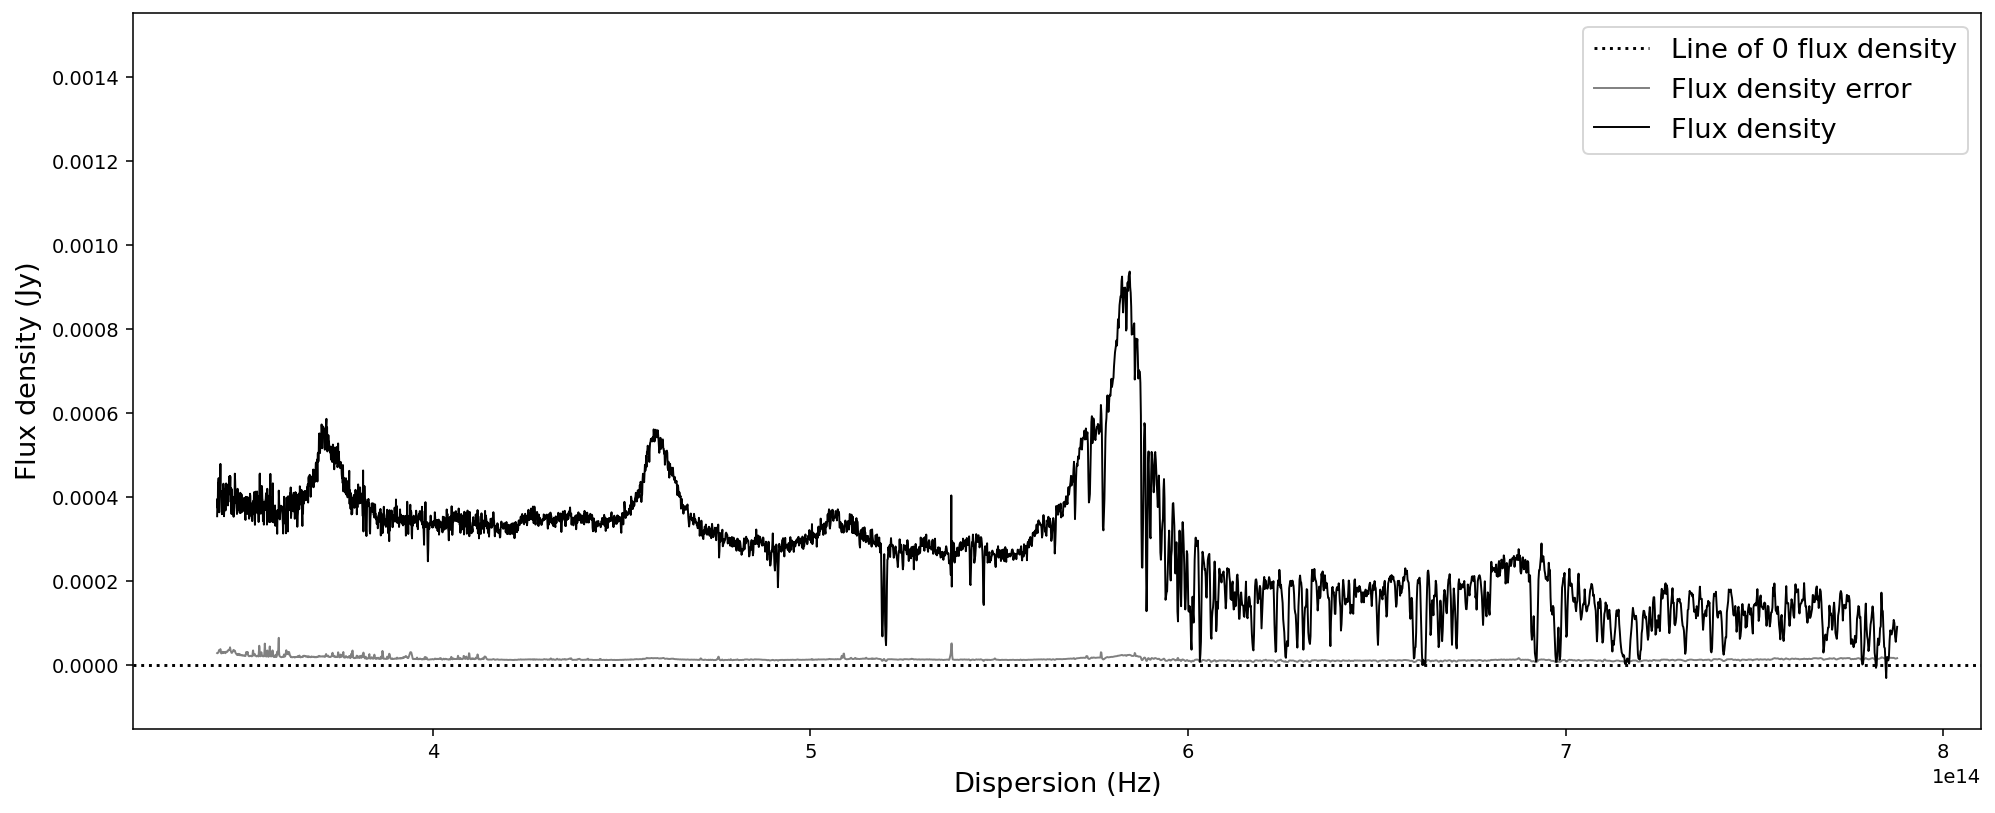

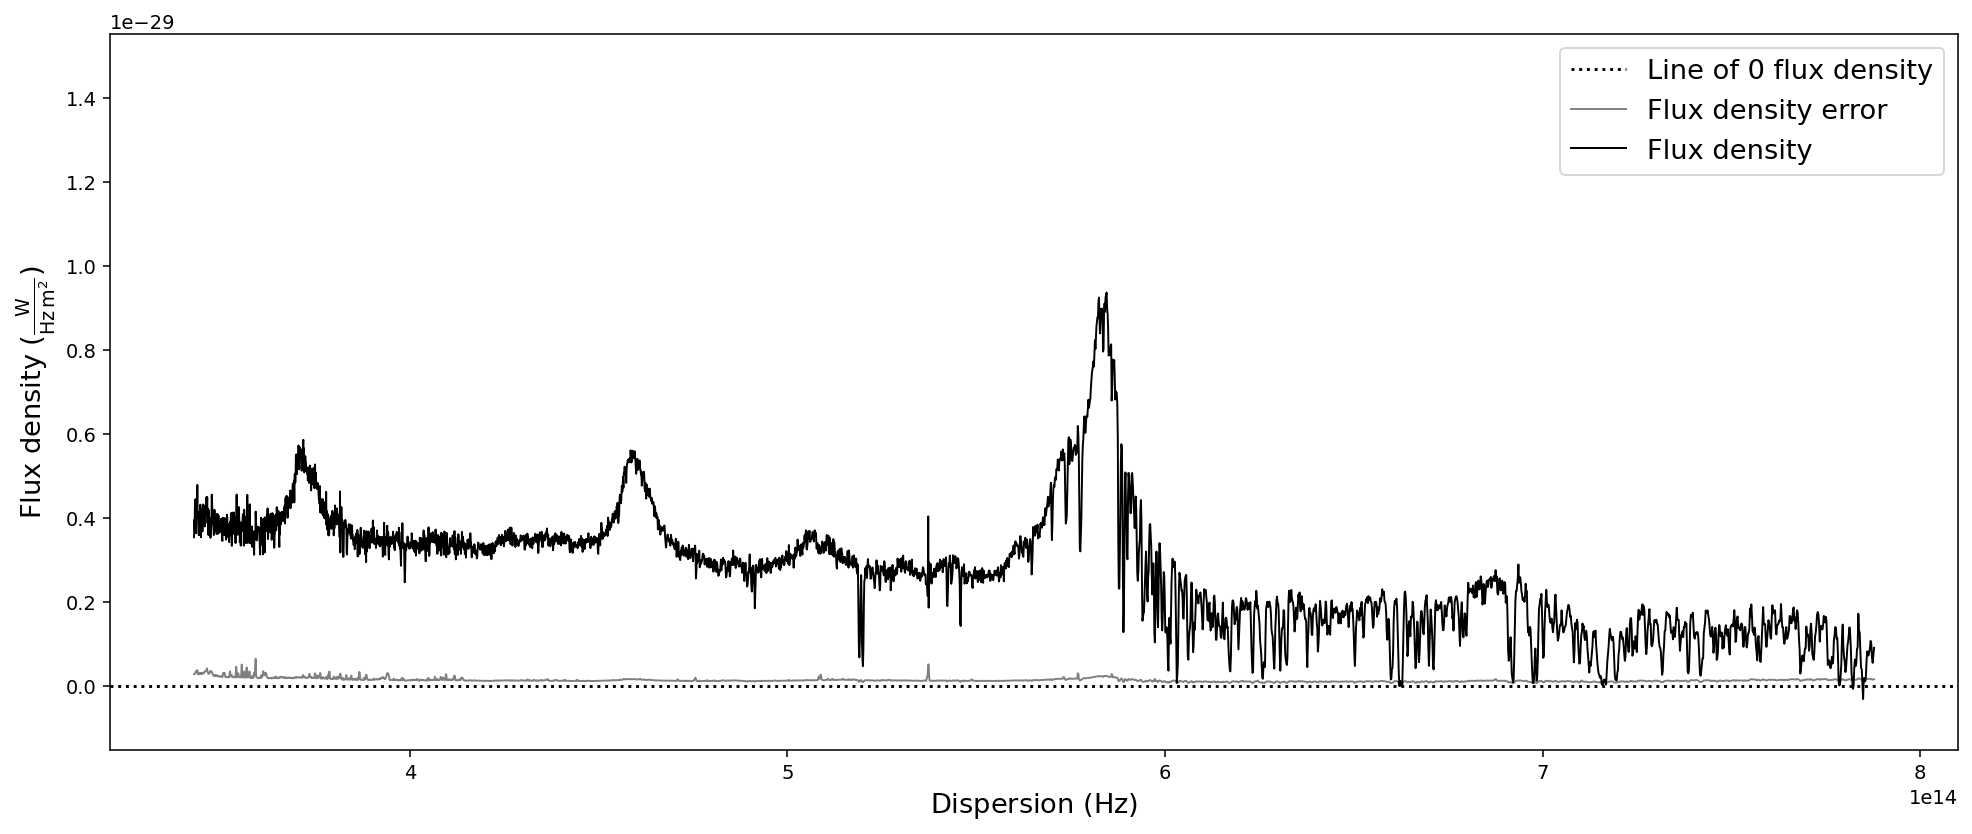

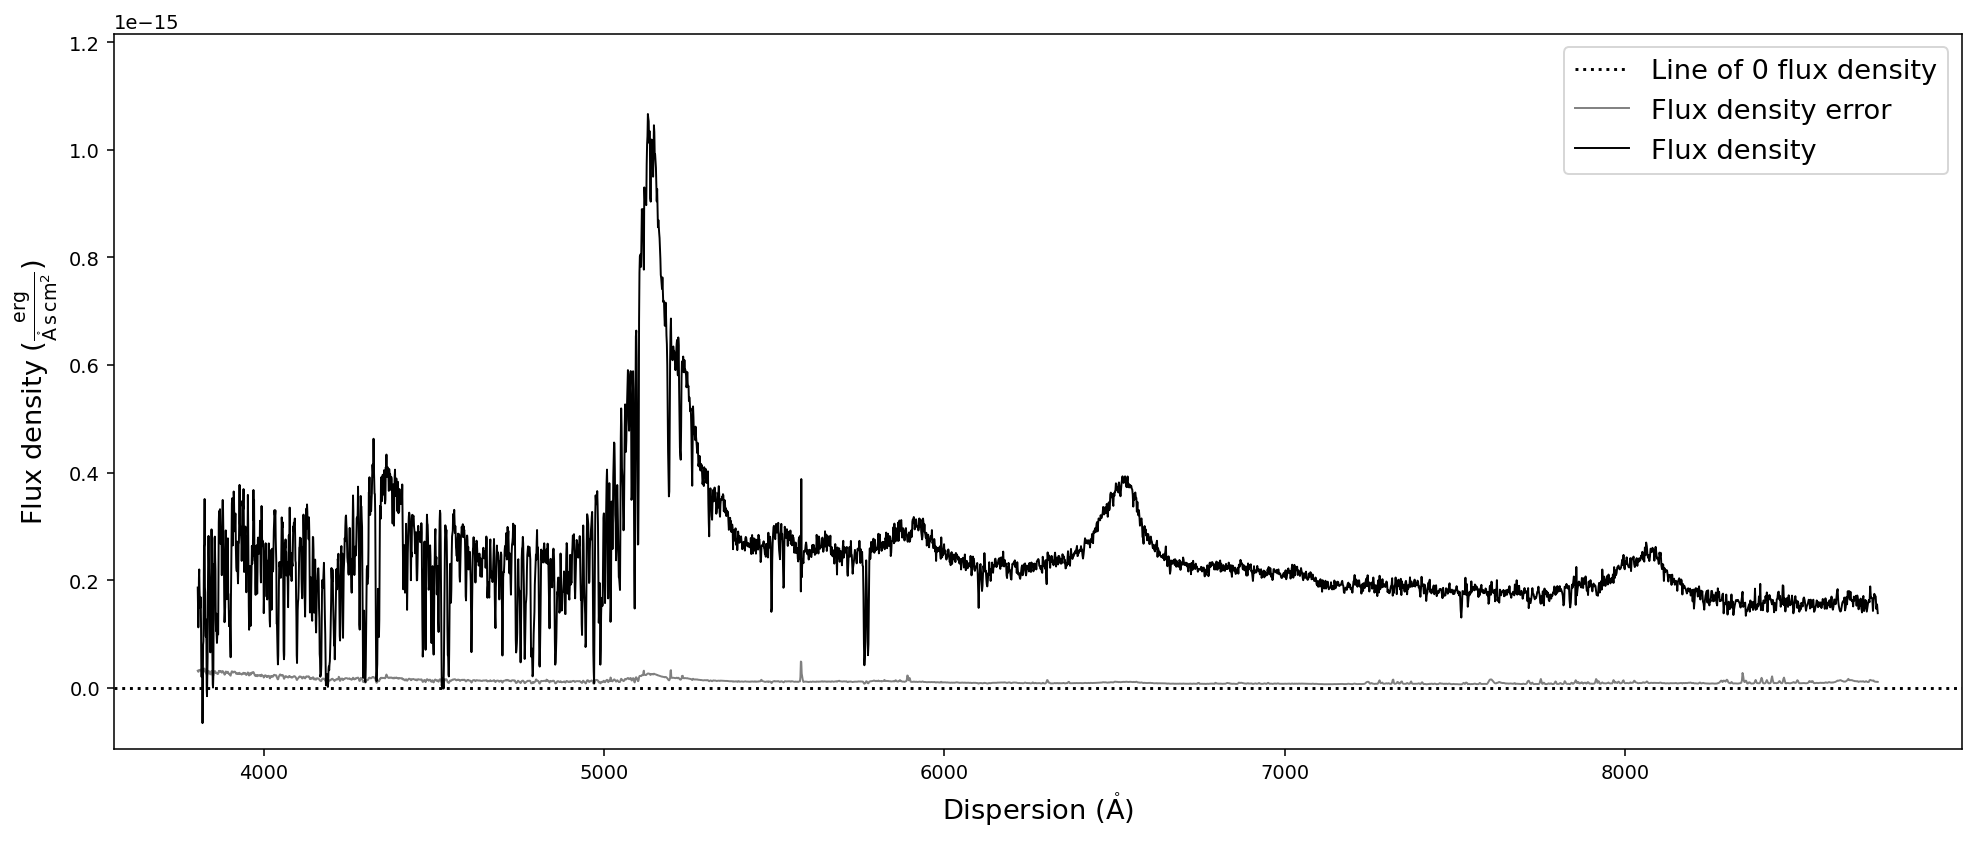

In [12]:
# Convert SpecOneD spectrum to flux density per unit frequency (Hz) in cgs units.
sdss_spec.to_fluxden_per_unit_frequency_cgs()
# Display the spectrum
sdss_spec.plot()

# Convert SpecOneD spectrum to flux density per unit frequency (Hz) in Jy.
sdss_spec.to_fluxden_per_unit_frequency_jy()
# Display the spectrum
sdss_spec.plot()

# Convert SpecOneD spectrum to flux density per unit frequency (Hz) in SI units.
sdss_spec.to_fluxden_per_unit_frequency_si()
# Display the spectrum
sdss_spec.plot()

# Convert SpecOneD spectrum to flux density per unit wavelength (Angstroem) in cgs units.
sdss_spec.to_fluxden_per_unit_wavelength_cgs()
# Display the spectrum
sdss_spec.plot()

After all these conversion the last one brought us back to flux density per unit wavelength in the same units that we originally read the spectrum in - with one major difference: the 1e-17 factor in front of the flux density has been multiplied to the numpy.ndarray of the flux density and been removed from the flux density unit.  However, in these particular units the flux density has very low numerical values, which could pose a problem to fitting algorithms. Therefore, we want to normalize the flux density numerical values and hide large factors in the unit. 

## "Normalizing" the flux density numpy.ndarray

Within SpecOneD we provide three functions that allow to "normalize" the flux density numpy.ndarray. The first function calculates the median flux density error and normalizes the flux density unit accordingly. 

**Note that these function return a new SpecOneD object by default. In fact, the majority of the SpecOneD functions that manipulate or modify the spectrum return a modified copy by defaul. This approach is designed to leave the original spectrum *untouched*. However, you can overwrite the original spectrum by using the *inplace* keyword argument of those functions and set it to *True*.**

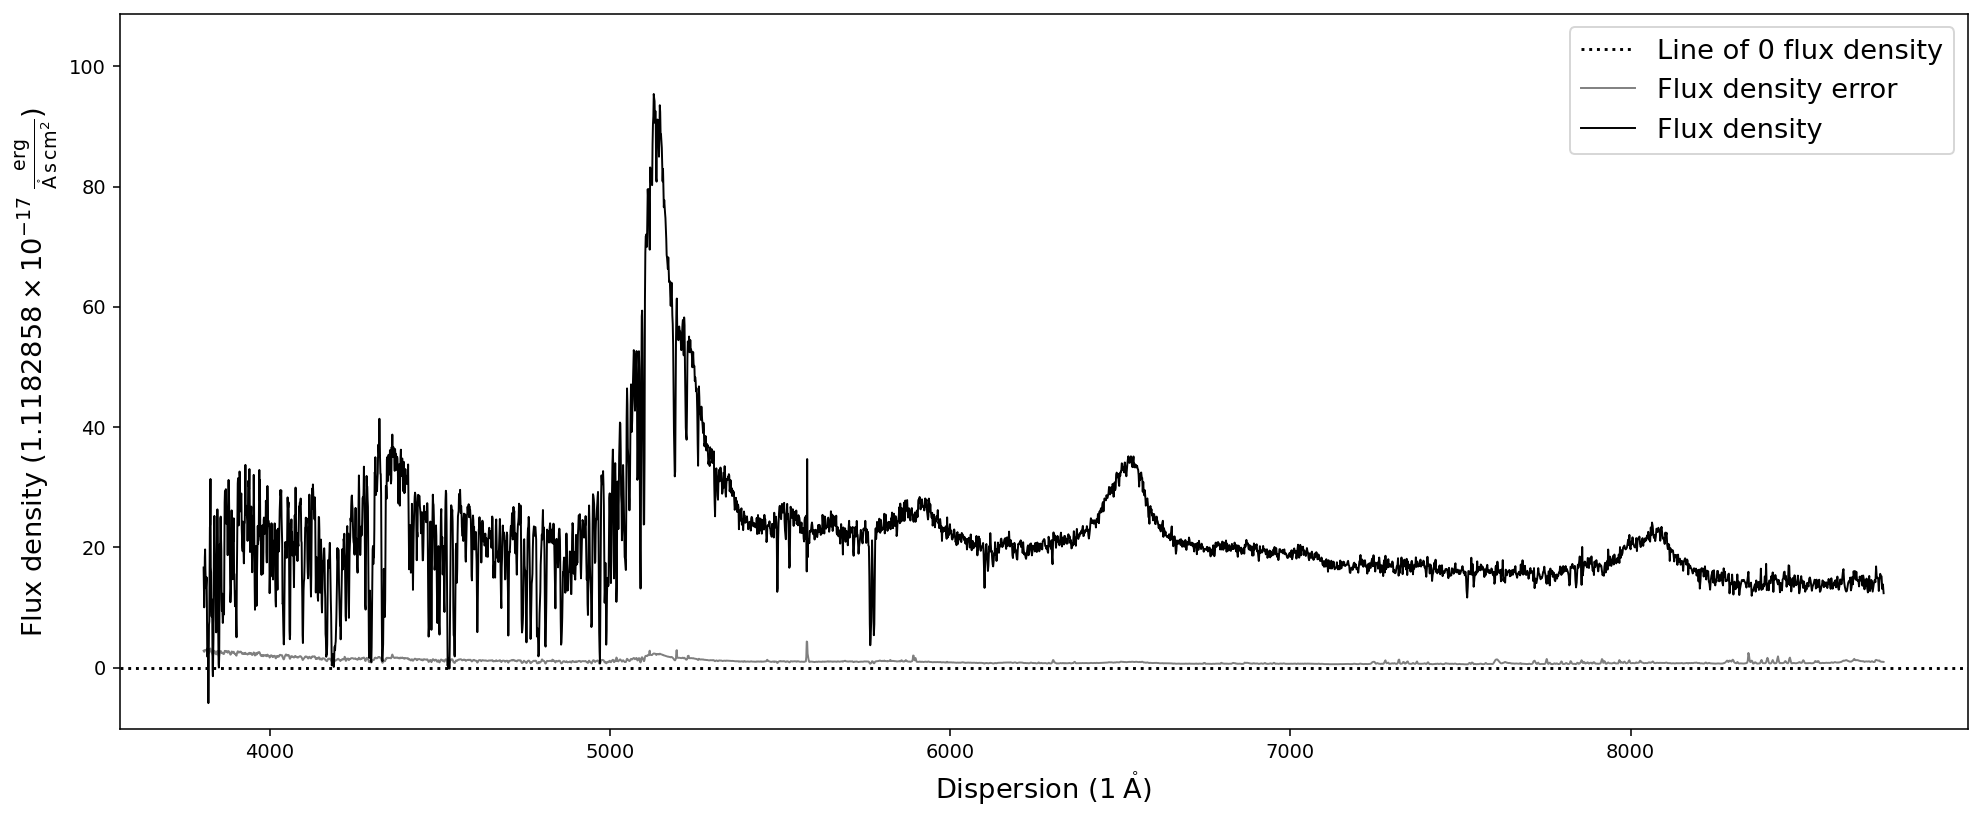

In [13]:
# Normalize flux density unit by flux density error
nspec = sdss_spec.normalize_fluxden_by_error()
nspec.plot()

As you can see, the flux density axis now shows that its unit is ~1.12 * 1e-17 erg/s/cm^2/A. However, in many cases we want to set a specific pre-factor to the flux density unit or modify it by a specific factor. For this purpose two additional functions exist:

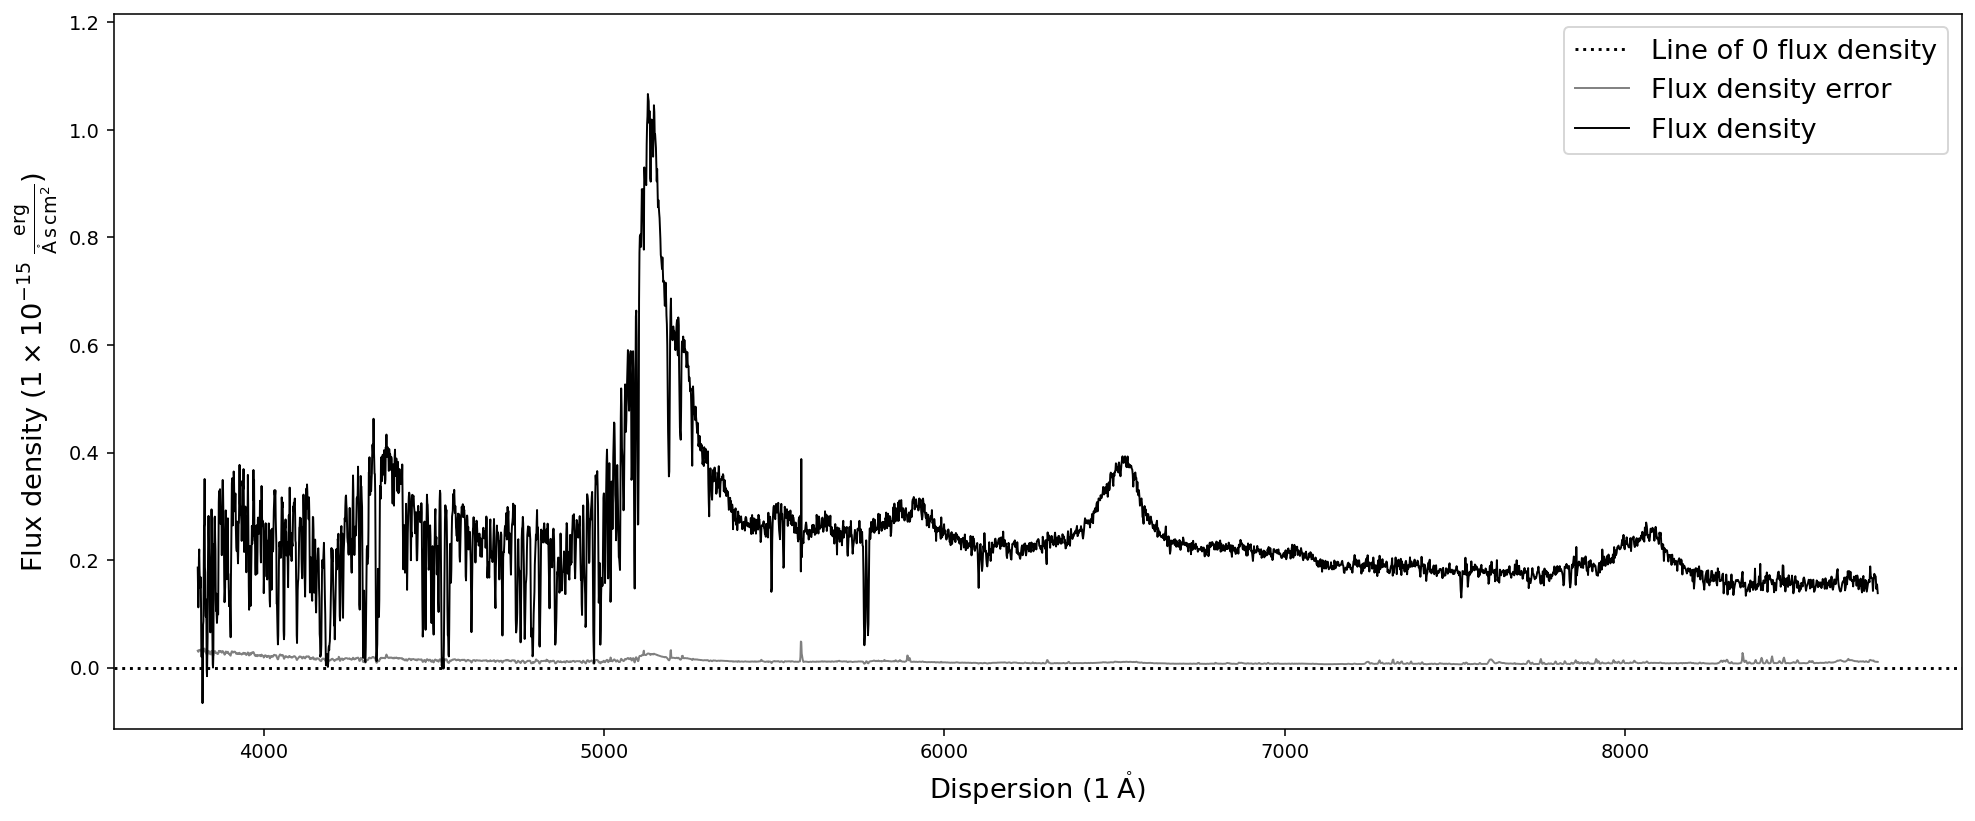

1e-30 erg / (Angstrom cm2 s)


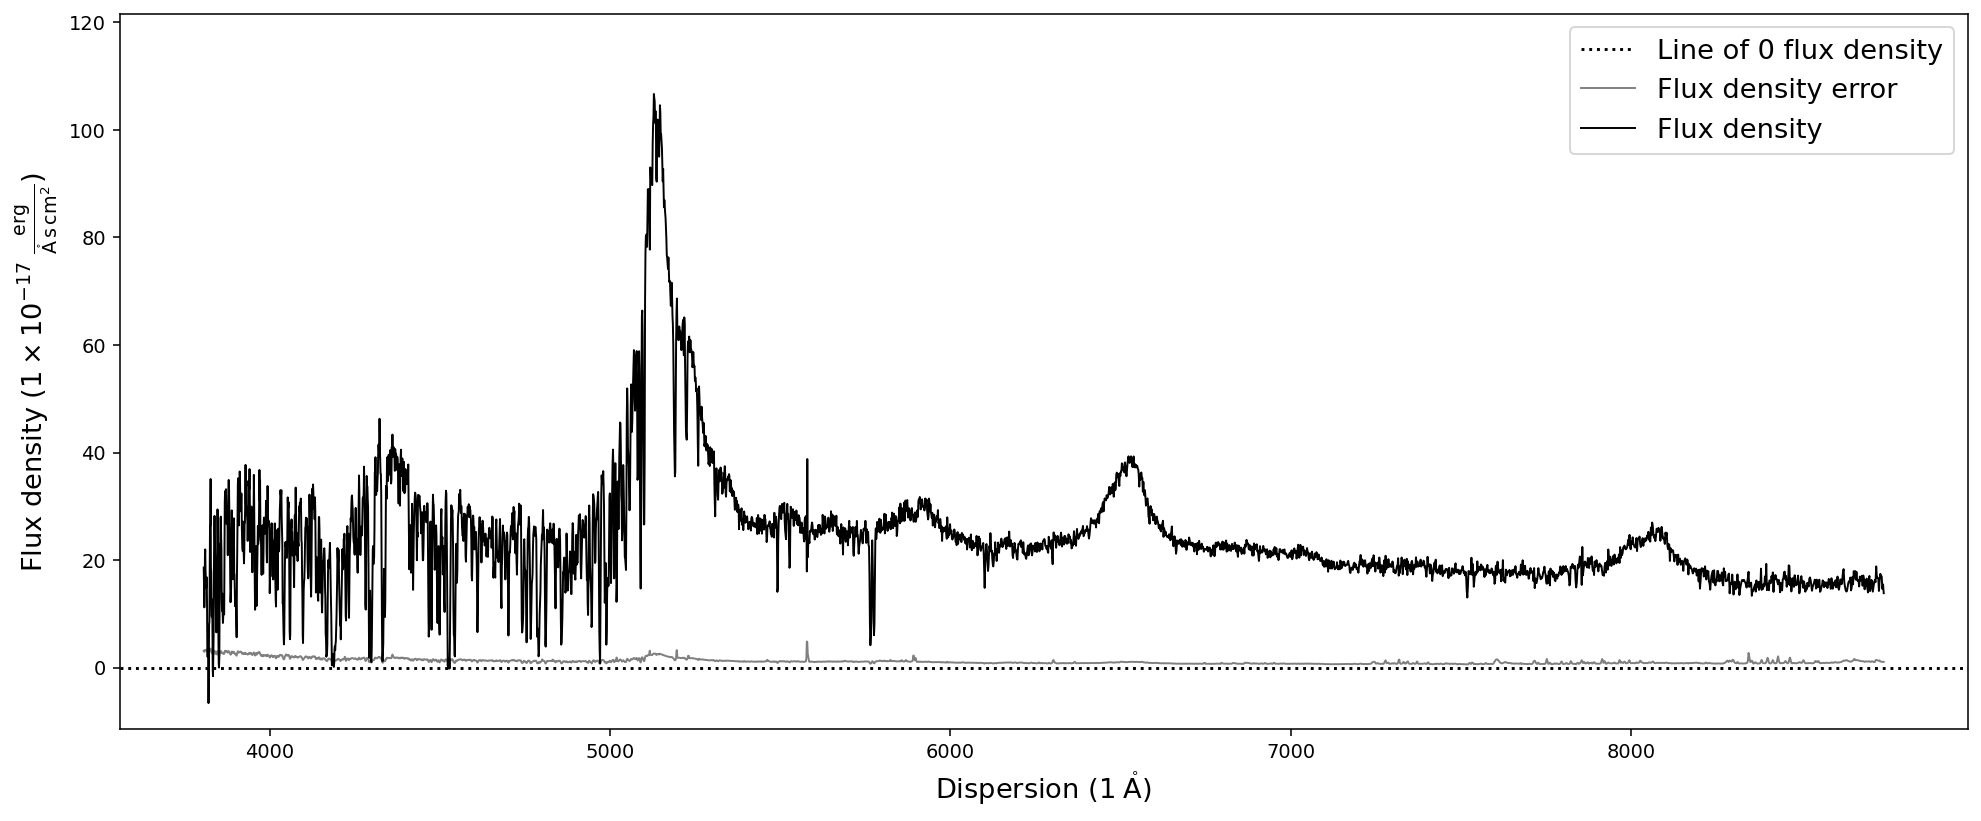

In [14]:
# Normalize the spectrum BY a specific unit factor of 1e-15.
nspec = sdss_spec.normalize_fluxden_by_factor(1e-15)
nspec.plot()

# Applying the same factor again, might lead to ridiculous pre-factors
print(nspec.normalize_fluxden_by_factor(1e-15).fluxden_unit)

# Normalize the spectrum TO a specific unit pre-factor
nspec = sdss_spec.normalize_fluxden_to_factor(1e-17)
nspec.plot()

## Manipulating spectra

In order to prepare the science spectrum for analysis one often has to manipulate the spectral data. This includes resampling the spectra to a pre-defined resolution, trimming the spectra, or matching multiple spectra to construct a composite spectrum. The SpecOneD class provides functionality for all of these cases. 

### Trimming spectra 

Trimming spectral data with SpecOneD is implemented in the function *trim_dispersion*. A tuple of two float values provide the lower and upper limits of the new spectrum. By default the numerical limits are assumed to be in units of the dispersion axis (*mode='physical'*) and trim the spectrum at the closest points in dispersion units. Alternatively, one can change the mode to *mode='pixel'* and then trim the spectra according to the pixel number. 
By default the function will return a new spectrum. In case the user wants to overwrite the old spectrum, one can specify this by *inplace=True* in the function. 
If we return a new spectrum, we can immediately plot it by chaining the *.plot()* function to the trimming function.

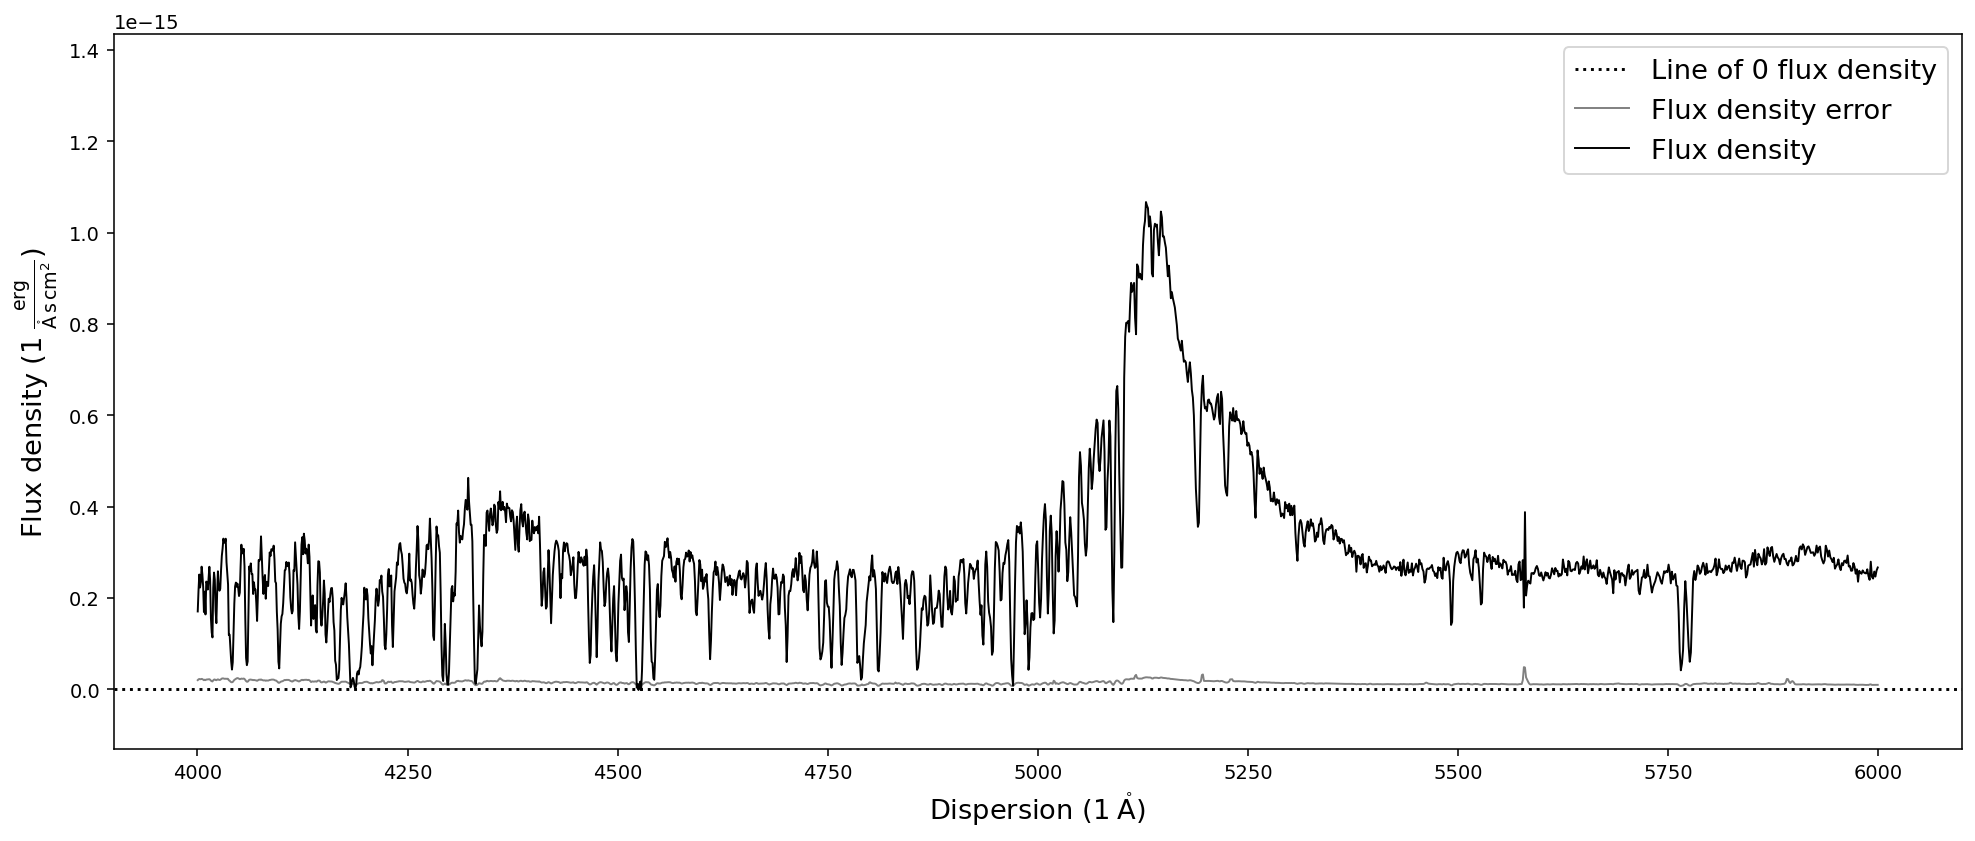

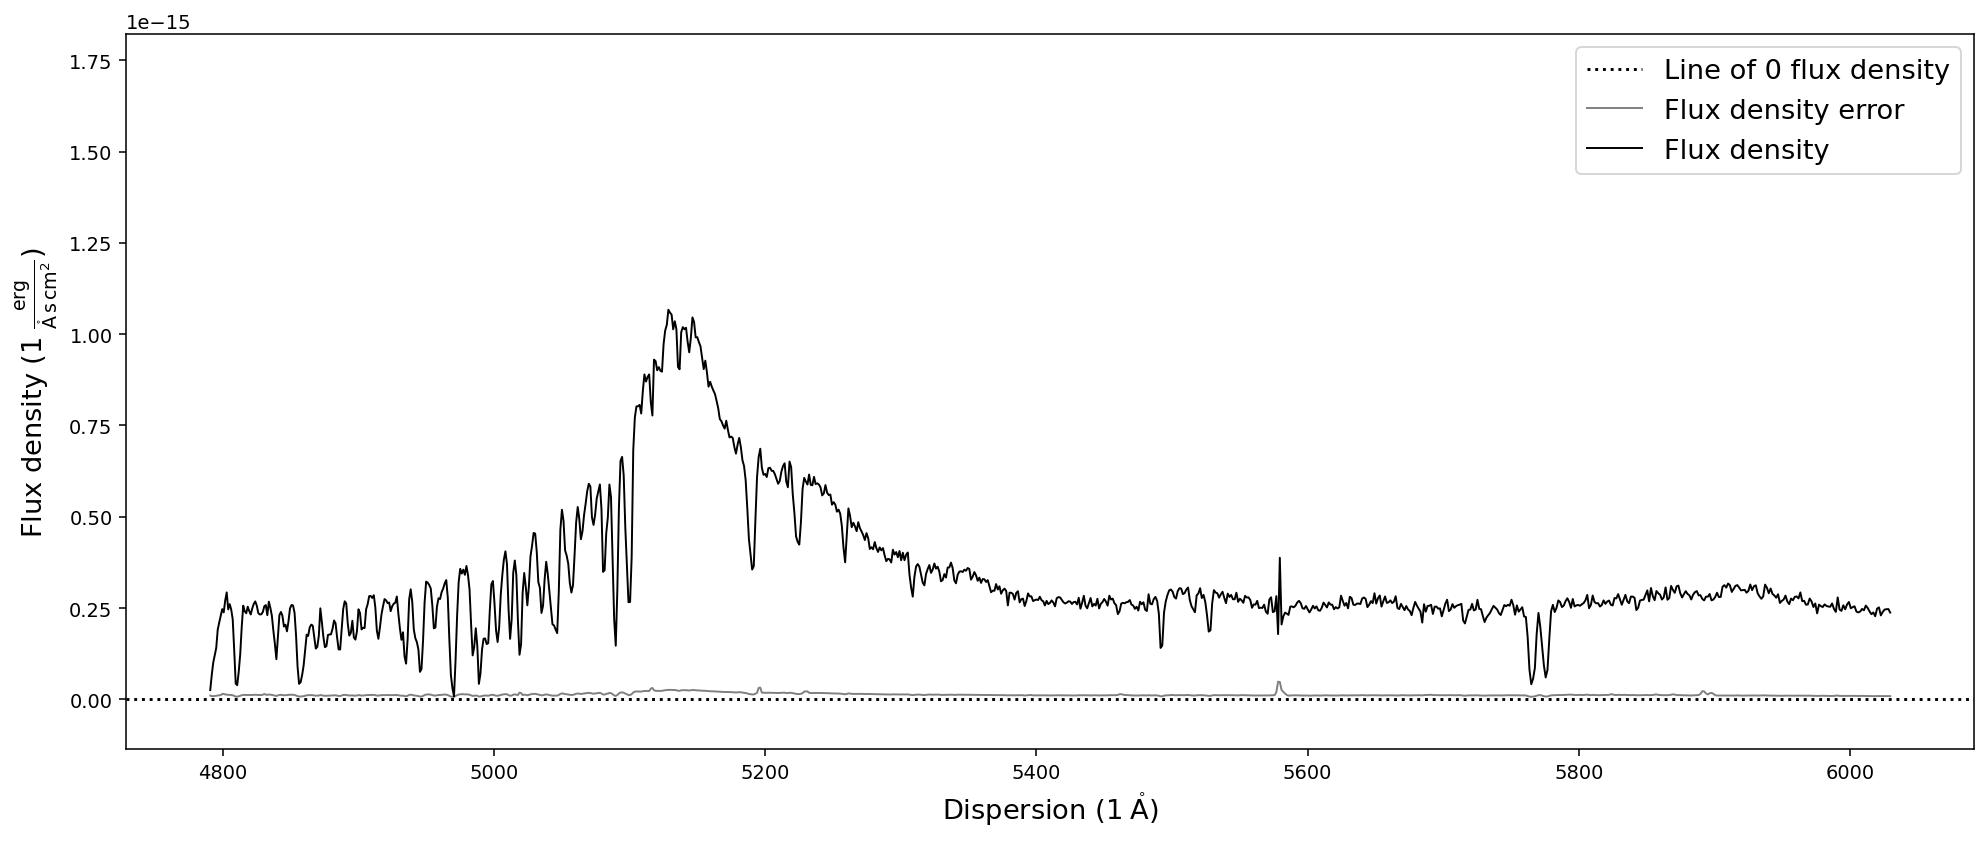

In [15]:
# Trim and plot the SDSS quasar spectrum in dispersion units
sdss_spec.trim_dispersion([4000,6000]).plot()

# Trim and plot the SDSS quasar spectrum in pixel units 
sdss_spec.trim_dispersion([1000,2000], mode='pixel').plot()

### Resampling 

In some cases one wants to resample the spectrum to a constant resolution to the resolution of another spectrum. For these cases SpecOneD uses [SpectRes package](https://github.com/ACCarnall/SpectRes) by Adam Carnall. The SpecOneD class provides a wrapper function called *resample* that applies the SpectRes resample method to the SpecOneD object. 

As an argument it takes the new resolution as an numpy.ndarray. 

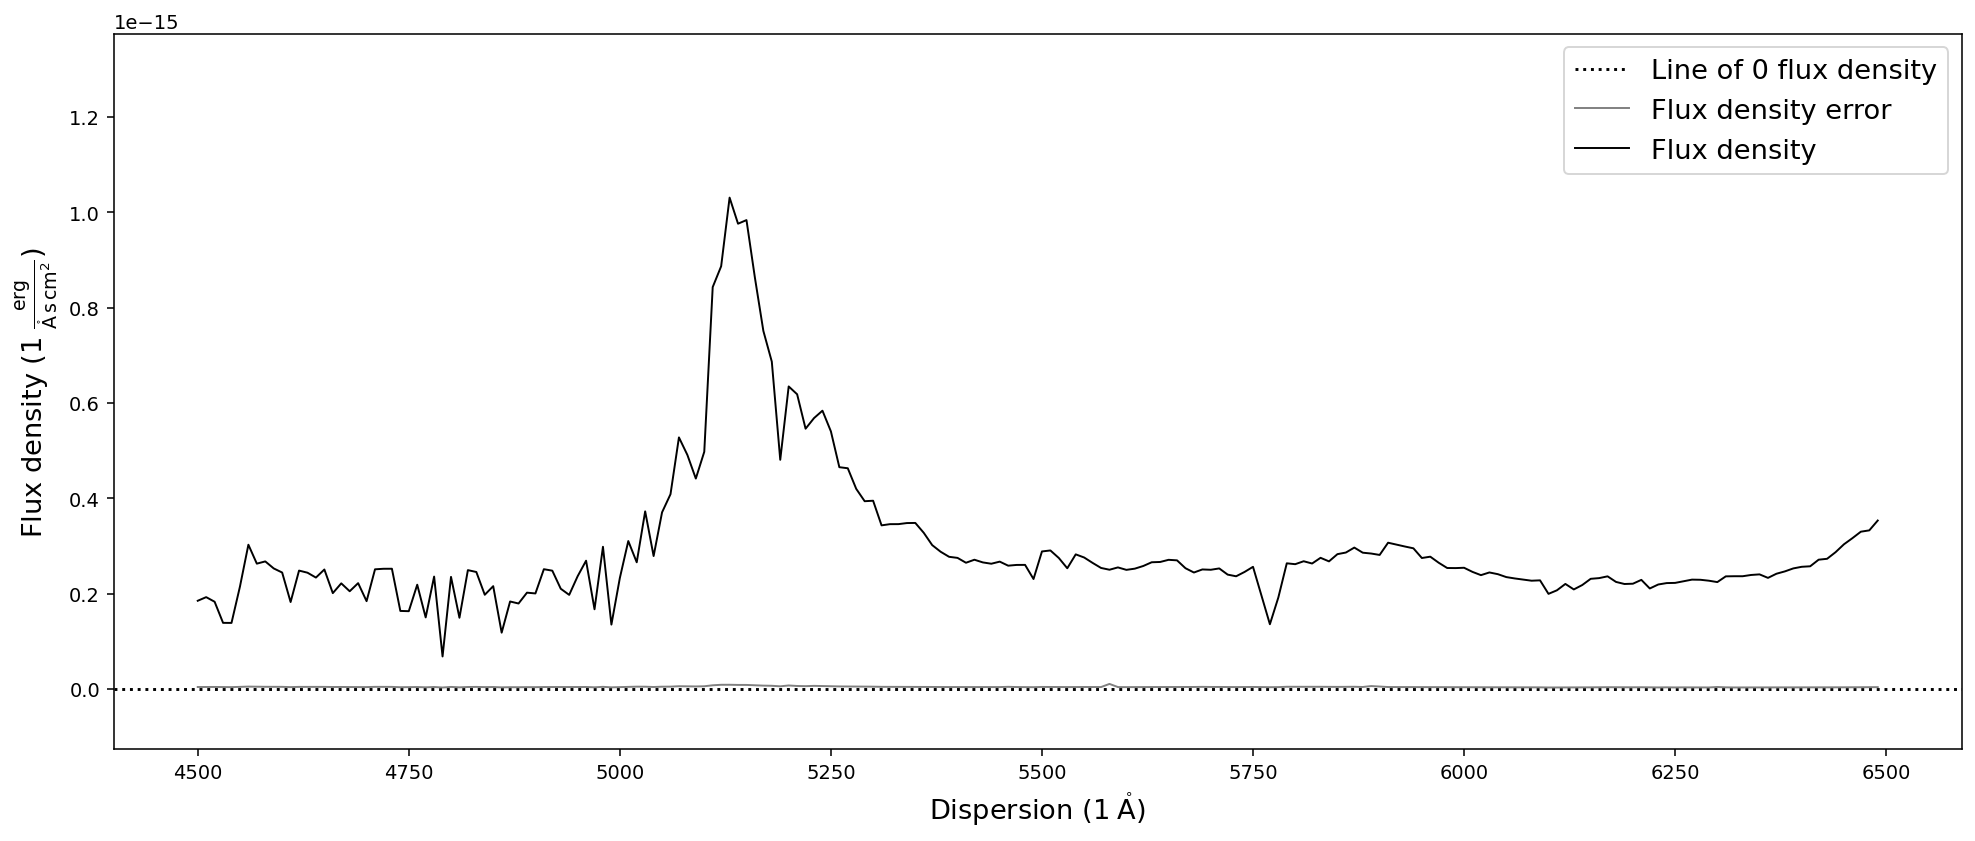

In [16]:
import numpy as np

# Setting up the new dispersion axis 
new_dispersion = np.arange(4500,6500,10)

sdss_spec.resample(new_dispersion).plot()

We have now created a lower resolution version of the previous SDSS quasar spectrum in the dispersion range of 4500A to 6500A. However, what happens if the new dispersion range is not covered by the spectrum?

In the current implementation this will automatically return an Error! However, one can set the keyword argument *force=True*, which will force the new dispersion range to be within the original spectral dispersion, trimming it automatically. This will prompt a warning message, so that the user is aware of the modifications by the function.

[WARNING] Forcing new spectral dispersion axis to be within the limits of the old spectral dispersion.


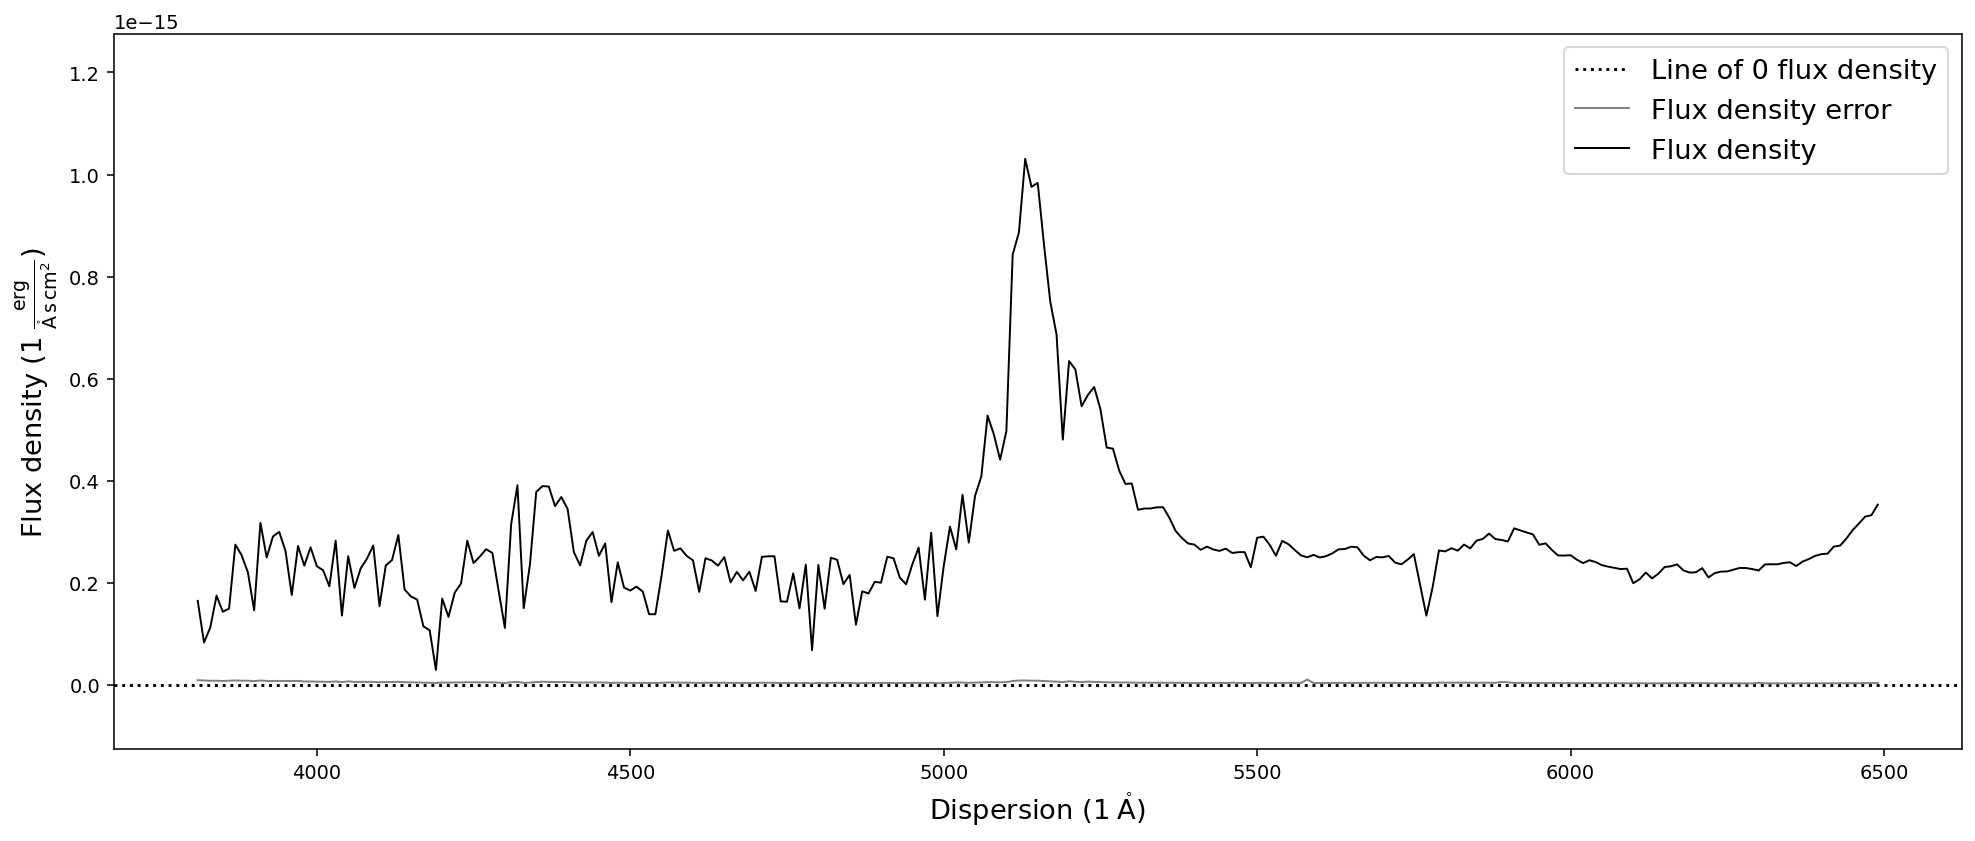

In [17]:
# Setting up the new dispersion axis 
new_dispersion = np.arange(2000,6500,10)

sdss_spec.resample(new_dispersion, force=True).plot()

### Reducing the spectral resolution via resampling & binning

In some cases it becomes necessary to reduce the resolution of a spectrum to increase the signal-to-noise ratio. Within the SpecOneD class this can either be achieved by resampling the spectrum to a dispersion with wider pixel sizes or by binning multiple pixels. 

The *resample_to_resolution* function uses the *resample* method discussed above to automatically the spectrum to a new dispersion axis with the resolution in km/s provided by the argument. The *buffer* keyword argument (default value = 2) determines how many pixels at the beginning and the end of the spectrum will be omitted in the resampling process. 

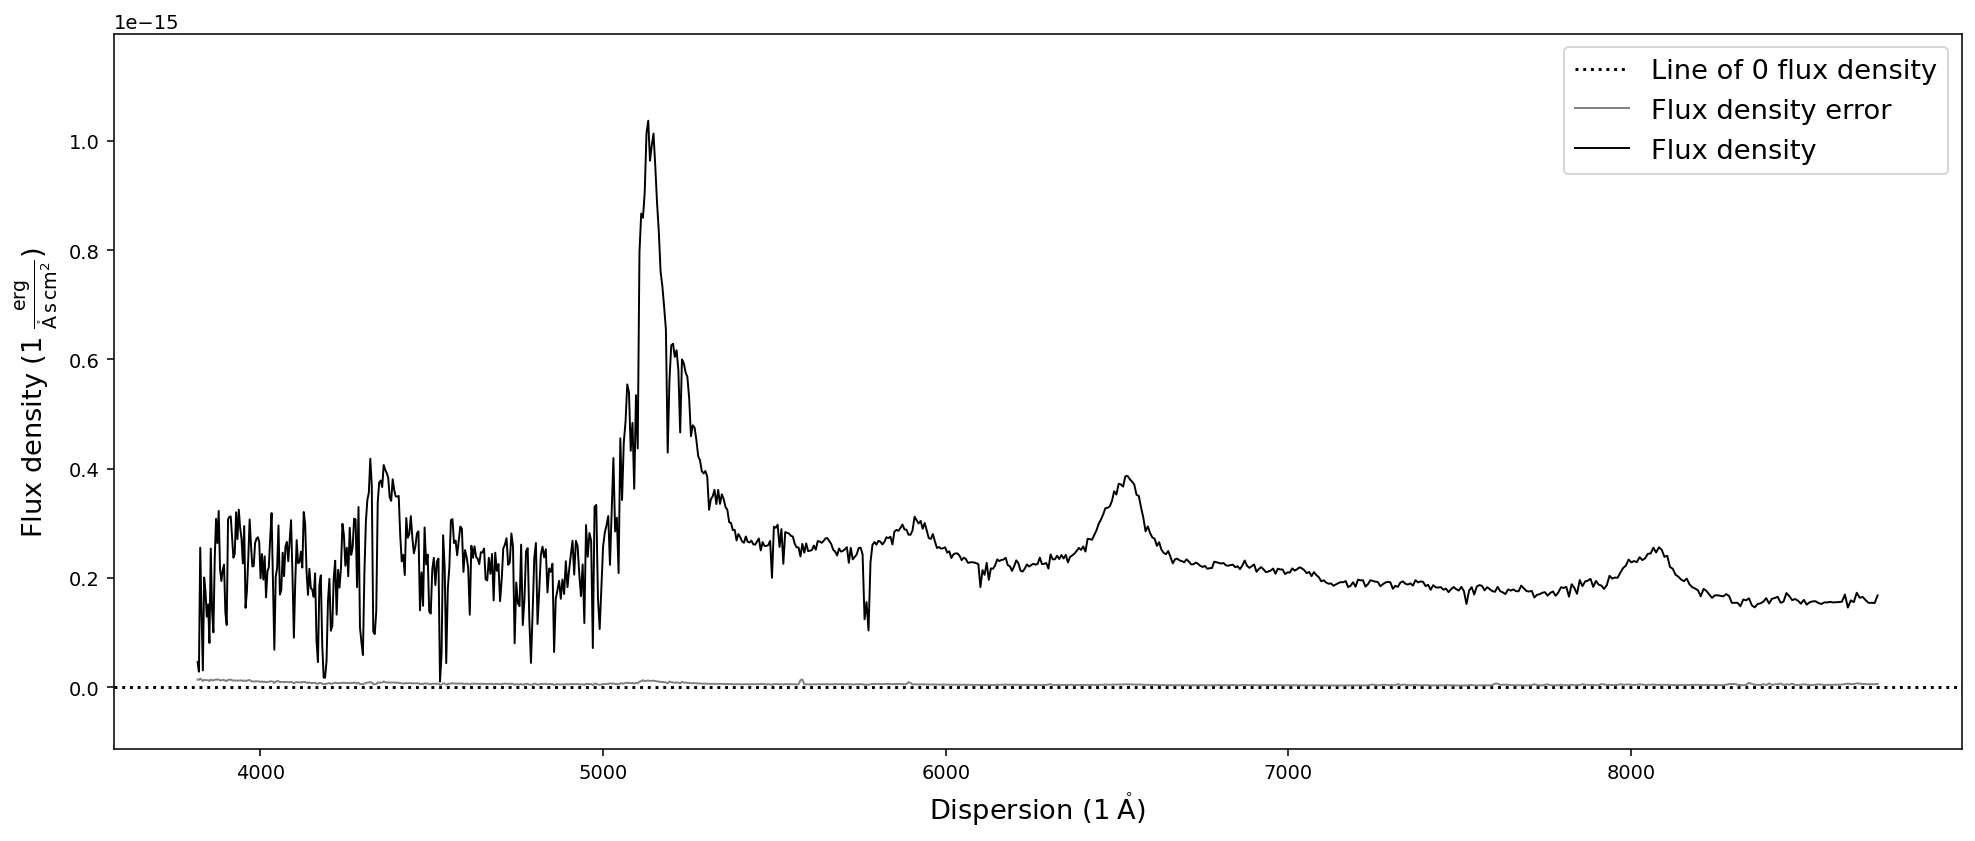

In [18]:
# Resample the spectrum to a resolution of 300 km/s
sdss_spec.resample_to_resolution(300).plot()

Binning the spectrum by an integer number of pixels can be achieve with the *bin_by_npixels* function. One has to simply specify the number of pixels that should be binned.

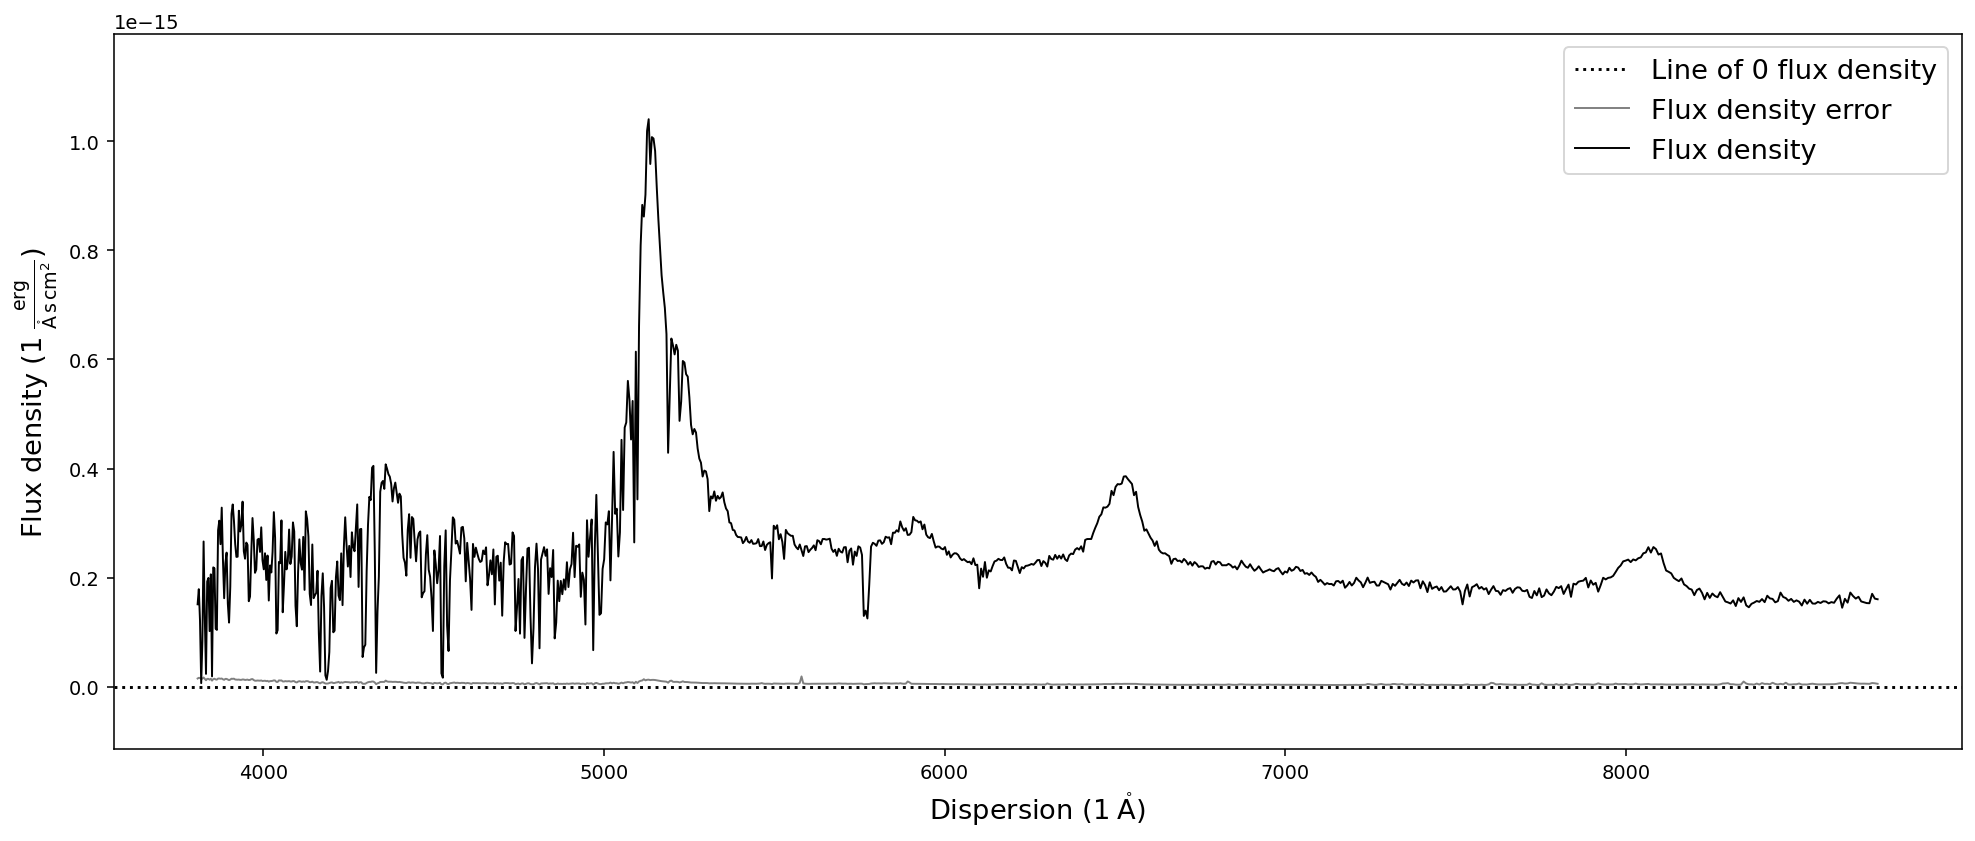

In [19]:
sdss_spec.bin_by_npixels(4).plot()

### Interpolating spectra

While interpolating spectra onto a new spectral axis will cause the flux density and flux density errors to be correlated, it can be useful in many cases (generating figures). In the SpecOneD module we use interpolation of spectral data onto new dispersion axis in a range of contexts. The functions *broaden_by_gaussian*, *calculate_passband_flux*, *calculate_passband_ab_magnitude* all use the *interpolate* function internally. 

The function uses the scipy.interpolate.interp1d method and takes the new dispersion as the argument. By default it will linearly interpolate (*kind='linear'*) the flux density and flux density error to the new dispersion axis, padding values outside the original dispersion range with a constant (*fill_value='const'*).

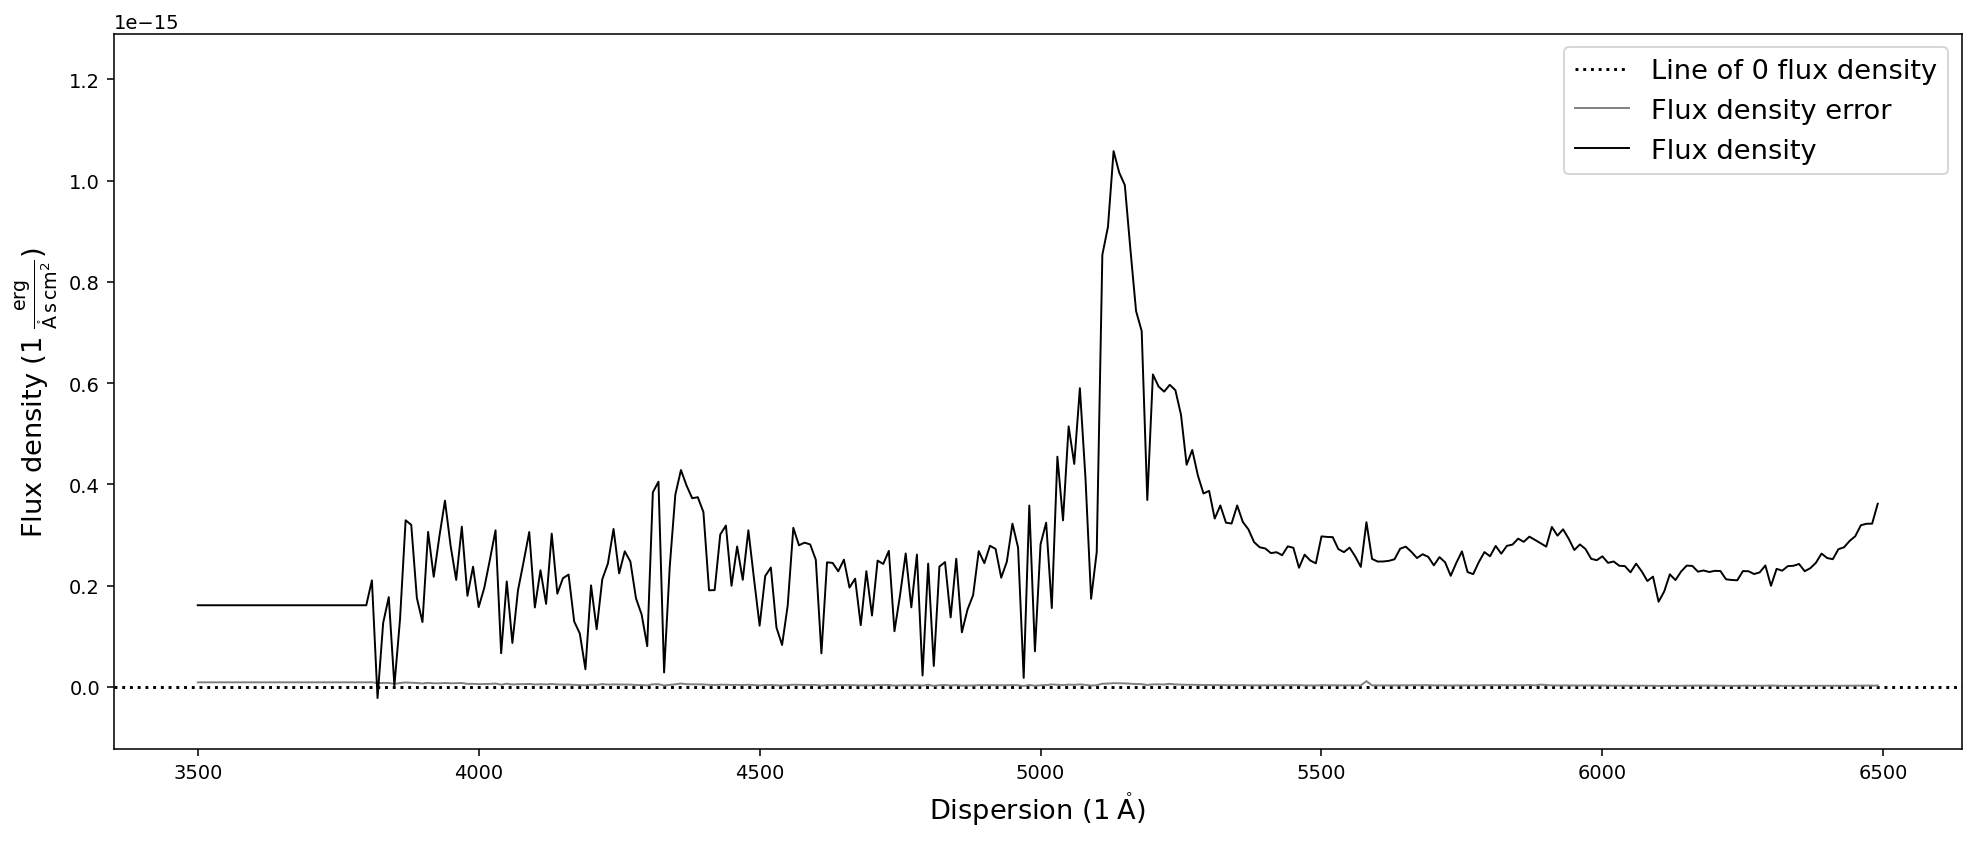

In [20]:
# Setting up the new dispersion axis 
new_dispersion = np.arange(3500,6500,10)

sdss_spec.interpolate(new_dispersion).plot()

There are differences between the *resample* and *interpolate* methods that are especially evident when sampled with a low resolution. In addition the SpectRes *resample* calculates the resulting flux density error more accurately, while the *interpolate* function only adjusts the signal to noise ratio by the resolution factor ( sqrt("old resolution"/"new resolution")).


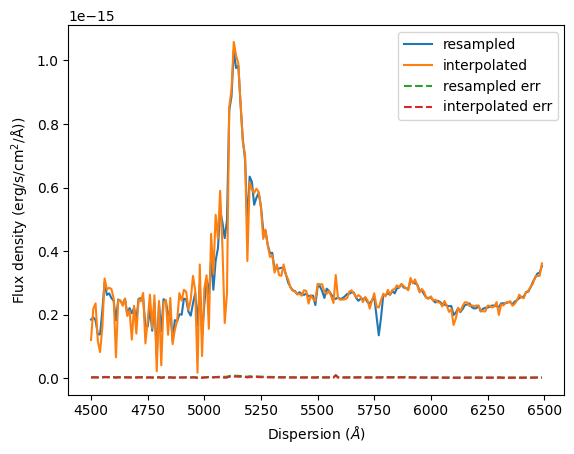

In [21]:
# Setting up the new dispersion axis 
new_dispersion = np.arange(4500,6500,10)

resampled = sdss_spec.resample(new_dispersion)
interpolated = sdss_spec.interpolate(new_dispersion)

import matplotlib.pyplot as plt 

plt.plot(resampled.dispersion, resampled.fluxden, label='resampled')
plt.plot(interpolated.dispersion, interpolated.fluxden, label='interpolated')
plt.plot(resampled.dispersion, resampled.fluxden_err, '--', label='resampled err')
plt.plot(interpolated.dispersion, interpolated.fluxden_err, '--', label='interpolated err')
plt.xlabel(r'Dispersion ($\AA$)')
plt.ylabel(r'Flux density ($\rm{erg}/\rm{s}/\rm{cm}^2/\AA$))')
plt.legend()
plt.show()

### Smoothing spectra
 
In addition the methods described above one can also smooth the spectrum using a boxcar or gaussian kernel. SpecOneD uses the astropy.convolution functionality to achieve this. The function takes the width (in pixels) of the kernel as an argument. Keyword arguments determine the kernel (default *kernel="boxcar"*) and whether the signal-to-noise ratio will be adjusted (default *scale_sigma=True*) by sqrt(width).

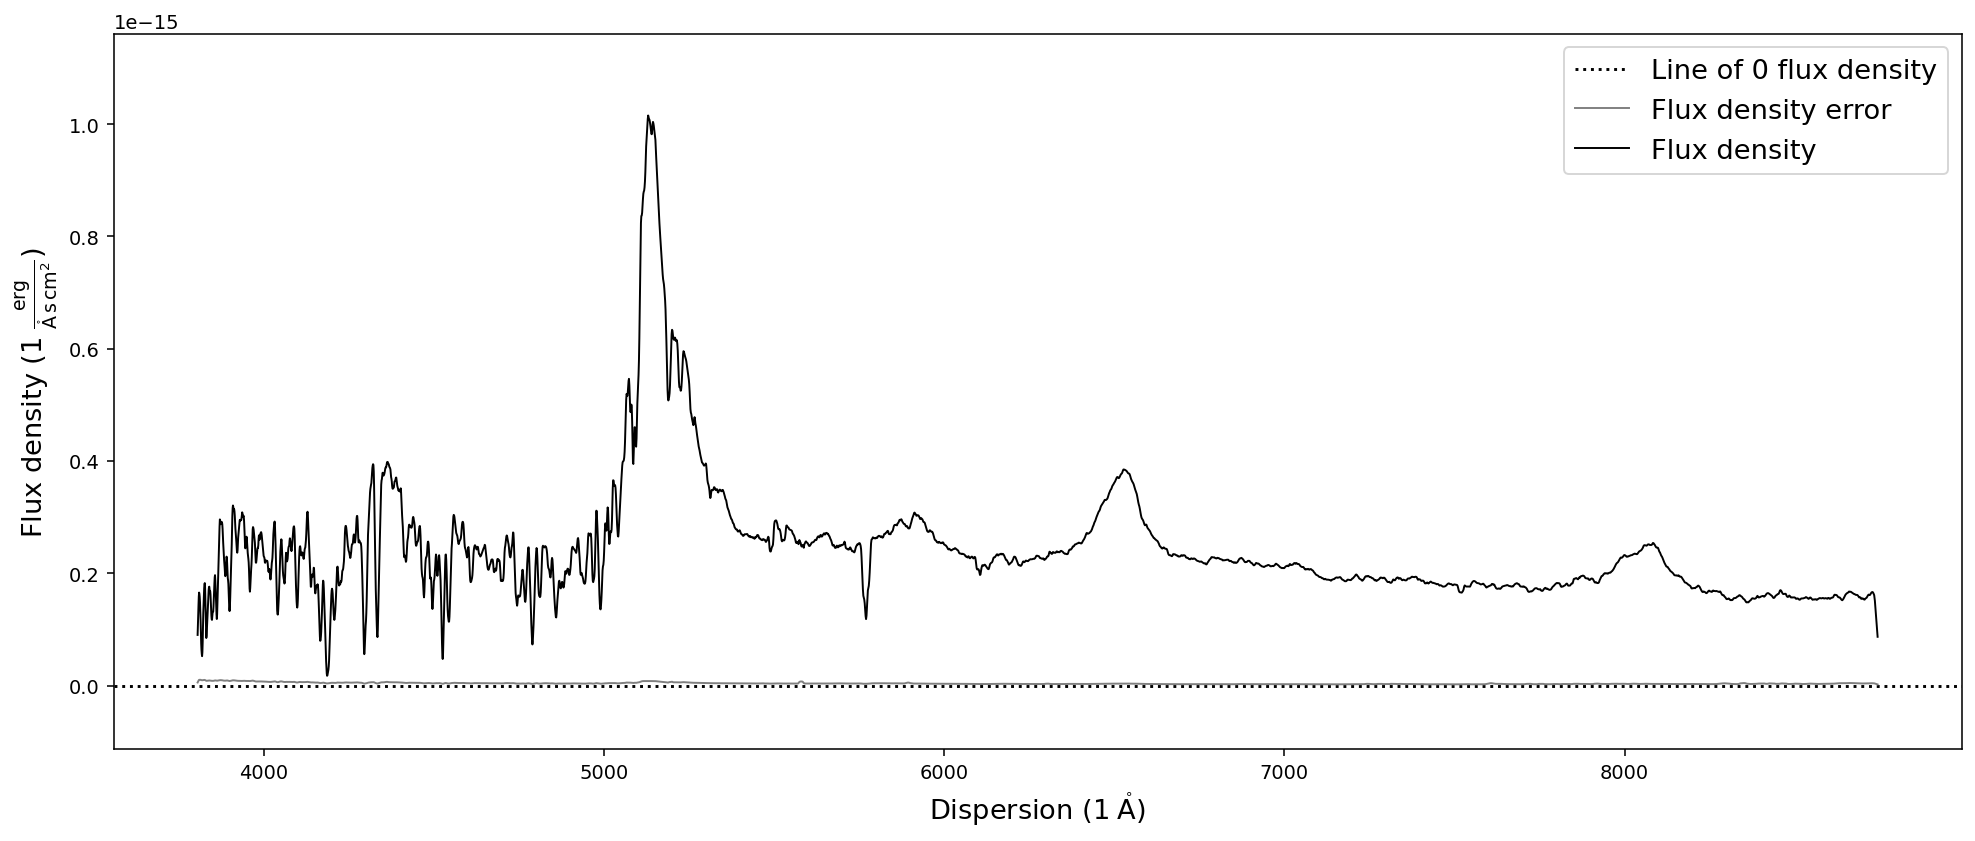

In [22]:
# Smooth the spectrum with a boxcar kernel of size 5 pixels and plot it
sdss_spec.smooth(10).plot()

### Matching spectra to the same dispersion axis

One of the applications of resampling spectra is to match two spectra of the same source, but observed with at different resolution to the same dispersion. 

For this purpose the SpecOneD class has a function called *match_dispersions*.  The documentation for this function reads: 
        
        Match the dispersion of the current spectrum and the secondary
        spectrum.

        Both, current and secondary, SpecOneD objects are modified in this
        process. The dispersion match identifies the maximum possible overlap
        in the dispersion direction of both spectra and automatically trims
        them to that range.

        If the current (primary) spectrum overlaps fully with the secondary
        spectrum the dispersion of the secondary will be interpolated/resampled
        to the primary dispersion.

        If the secondary spectrum overlaps fully with the primary, the primary
        spectrum will be interpolated/resampled on the secondary spectrum
        resolution, but this will only be executed if 'force==True' and
        'match_secondary==False'.

        If there is partial overlap between the spectra and 'force==True'
        the secondary spectrum will be interpolated/resampled to match the
        dispersion values of the primary spectrum.

        If there is no overlap a ValueError will be raised.
        
We now demonstrate how use this function with a quick example. We use two spectra from the example folder of the ultra-luminous quasar J2125-1719. These optical spectra cover a different dispersion range, so we will see how the function works in this case.

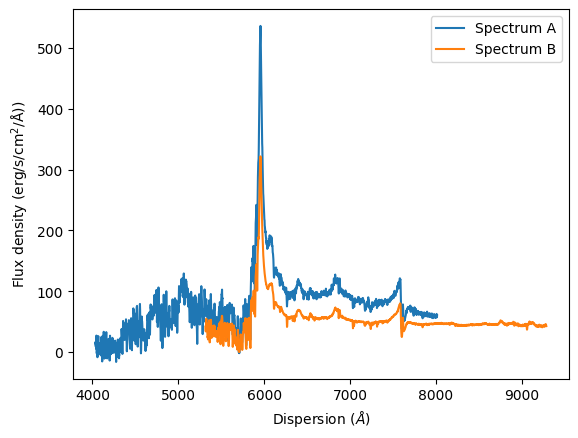

In [23]:
# Read in the spectra of J2125-1719 
specoptA = sod.SpecOneD()
specoptA.read_from_fits('../../speconed/data/example_spectra/J2125-1719_OPT_A.fits')
specoptB = sod.SpecOneD()
specoptB.read_from_fits('../../speconed/data/example_spectra/J2125-1719_OPT_B.fits')

# The optical spectra will be scaled to 1e-17 erg/s/cm^2/A
specoptA.convert_spectral_units(1.*units.AA, 1e-17*units.erg/units.s/units.cm**2/units.AA)
specoptB.convert_spectral_units(1.*units.AA, 1e-17*units.erg/units.s/units.cm**2/units.AA)

# Plot the spectra before matching them 
plt.plot(specoptA.dispersion, specoptA.fluxden, label='Spectrum A')
plt.plot(specoptB.dispersion, specoptB.fluxden, label='Spectrum B')
plt.xlabel(r'Dispersion ($\AA$)')
plt.ylabel(r'Flux density ($\rm{erg}/\rm{s}/\rm{cm}^2/\AA$))')
plt.legend()
plt.show()

Now we will use the match dispersion function to match the dispersion of spectrum A to spectrum B. The *match_secondary* keyword indicates whether the secondary dispersion axis will always be matched to the primary spectrum of if the reverse is allowed. The default matching method is interpolation (*method='interpolate')*.

If the primary spectrum (here specoptA) is not fully contained within the dispersion range of the secondary spectrum (here specoptB), we need to set *force=True* to allow the primary spectrum to be reduced to the overlap region of both spectra.

**Note that the *match_dispersions* function does NOT have a *inplace* keyword argument. This functions ALWAYS modifies both original spectra!**

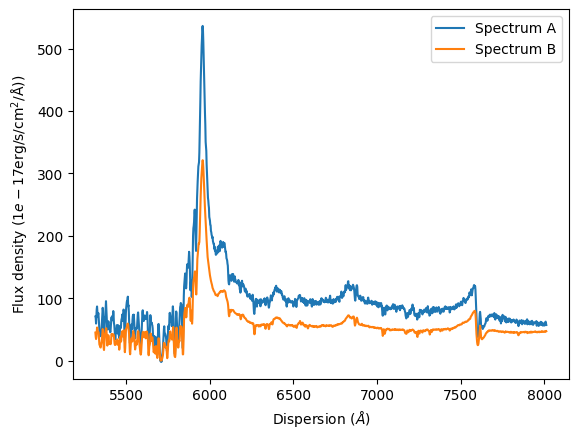

In [24]:
specoptA.match_dispersions(specoptB, match_secondary=True,
                          force=True, method='interpolate',
                          interp_method='linear')
# Plot the spectra AFTER matching them 
plt.plot(specoptA.dispersion, specoptA.fluxden, label='Spectrum A')
plt.plot(specoptB.dispersion, specoptB.fluxden, label='Spectrum B')
plt.xlabel(r'Dispersion ($\AA$)')
plt.ylabel(r'Flux density ($1e-17\rm{erg}/\rm{s}/\rm{cm}^2/\AA$))')
plt.legend()
plt.show()

The plot illustrates that both spectra have been automatically cut to their overlap region. In this range the dispersion axes of both spectra are now identical.

In [25]:
print(specoptA.dispersion)
print(specoptB.dispersion)

[5316.3259873  5318.30567772 5320.28536813 ... 8008.70494917 8010.68463959
 8012.66433   ]
[5316.3259873  5318.30567772 5320.28536813 ... 8008.70494917 8010.68463959
 8012.66433   ]


### Renormalize the flux density between two spectra

The SpecOneD class also includes methods to renormalize the spectral flux density either to a secondary spectrum or a passband magnitude. For now we will demonstrate how one can match the flux density of one spectrum to a different one in their overlap region. For this example we use the optical spectra of quasar J2125-1719 above.

The SpecOneD function to carry out the renormalization is aptly named *renormalize_by_spectrum*.

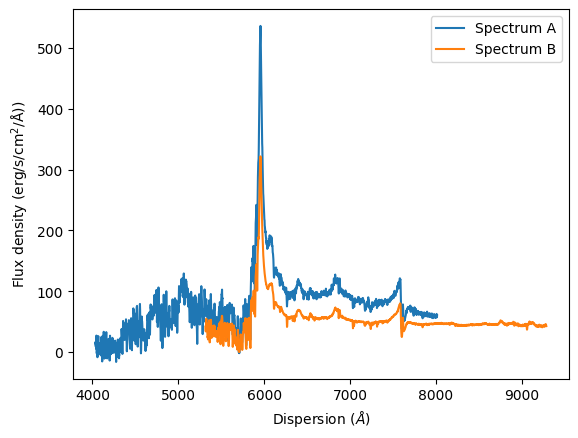

In [26]:
# Read in the spectra of J2125-1719 
specoptA = sod.SpecOneD()
specoptA.read_from_fits('../../speconed/data/example_spectra/J2125-1719_OPT_A.fits')
specoptB = sod.SpecOneD()
specoptB.read_from_fits('../../speconed/data/example_spectra/J2125-1719_OPT_B.fits')

# The optical spectra will be scaled to 1e-17 erg/s/cm^2/A
specoptA.convert_spectral_units(1.*units.AA, 1e-17*units.erg/units.s/units.cm**2/units.AA)
specoptB.convert_spectral_units(1.*units.AA, 1e-17*units.erg/units.s/units.cm**2/units.AA)

# Plot the spectra before renomalizing the flux density
plt.plot(specoptA.dispersion, specoptA.fluxden, label='Spectrum A')
plt.plot(specoptB.dispersion, specoptB.fluxden, label='Spectrum B')
plt.xlabel(r'Dispersion ($\AA$)')
plt.ylabel(r'Flux density ($\rm{erg}/\rm{s}/\rm{cm}^2/\AA$))')
plt.legend()
plt.show()

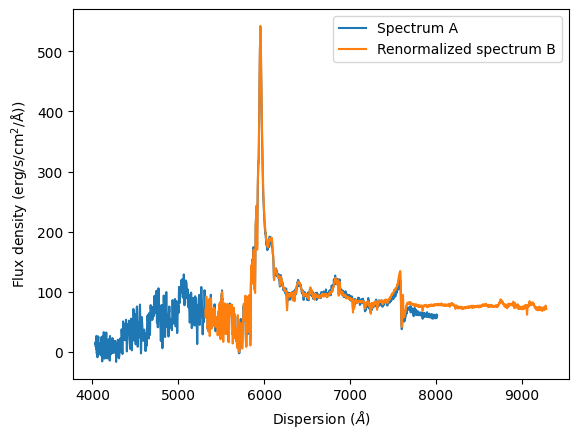

In [27]:
# Renormalize the flux density of spectrum B to spectrum A in the overlap region of 6000A-7000A.
nspecoptB = specoptB.renormalize_by_spectrum(specoptA, dispersion_limits=[6000,7000])

# Plot the spectra after renomalizing the flux density
plt.plot(specoptA.dispersion, specoptA.fluxden, label='Spectrum A')
plt.plot(nspecoptB.dispersion, nspecoptB.fluxden, label='Renormalized spectrum B')
plt.xlabel(r'Dispersion ($\AA$)')
plt.ylabel(r'Flux density ($\rm{erg}/\rm{s}/\rm{cm}^2/\AA$))')
plt.legend()
plt.show()

If the dispersion limits for the overlap region are not specified, the full dispersion overlap of both spectra will be automatically chosen. 
**If one decides to choose dispersion limits that are not appropriate, the function will NOT stop you from doing so and return an incorrectly scaled spectrum.**

The default *output_mode* (*output_mode='spectrum'*) returns a SpecOneD object. Alternatively one can specify *output_mode='flux_factor'* and the function will return the factor by which the spectrum should be scaled to match the flux density of the other one as a float value. 

In [28]:
# Calculate the scaling factor to scale spectrum B to spectrum A in the overlap region of 6000A-7000A.
print(specoptB.renormalize_by_spectrum(specoptA, dispersion_limits=[6000,7000], output_mode='flux_factor'))

1.6855747992533456


# The PassBand class

The PassBand class is a child class of SpecOneD designed to store and manipulate filter transmission curves from various telescopes. The SpecOneD package includes a range of filter transmission curves from various sources in the data/passbands folder. 

These transmission curves can be automatically loaded into PassBand objects by using their name (omitting the .dat extension). They provide important functionality to the SpecOneD class for calculating passband fluxes or magnitudes and allow absolute flux normalization by the passband AB magnitude. 

Let us start by loading the SDSS r-band filter provided by SpecOneD.

In [29]:
# Initialize the SDSS r-band filter as a PassBand object
pb = sod.PassBand('SDSS-r')

# Plot the SDSS r-band using the built in plot functionality
pb.plot()

FileNotFoundError: /opt/miniconda3/envs/speconed/lib/python3.10/site-packages/speconed/data/passbands/SDSS-r.dat not found.

Many SpecOneD functions that manipulate the dispersion axis also work on passbands. This includes *trim_dispersion* or *match_dispersion*, for example. However, some functionality requires flux densities and flux density errors and thus won't work with the PassBand class.

## Calculating the spectral flux through a passband

### Passband flux

For this example we will use the quasar spectrum of J030341.04-002321.8 again. We have already initialized the SDSS r-band as pb above, which we will be using in this example. The function that calculates the total passband flux is *calculate_passband_flux*. 

**Disclaimer: This function is written for passbands in quantum efficiency. Therefore, the (h*nu)^-1 term is not included in the integral.**

Therefore, if you want to use passbands that are not in quantum efficiency you need to write your own function. 

To match the passband and the spectrum to the same dispersion axis we can use either the *resample* or the *interpolate* methods described above. The lead to slightly different results, as can be seen below. If the spectrum does not fully overlap the passband one can set *force=True* to calculate the flux only in the overlap region. For this example we do not need to do that. (Setting *force=True* also prompts multiple warnings instructing the user to be especially careful with the intepretation of the results!)

In [ ]:
# Read in the sdss quasar spectrum 
spec.read_sdss_fits('../../speconed/data/example_spectra/J030341.04-002321.8_0.fits')

# Calculate the passband flux using the interpolate method to match the dispersions.
print(spec.calculate_passband_flux(pb, force=False, match_method='interpolate'))
# Calculate the passband flux using the resample method to match the dispersions.
print(spec.calculate_passband_flux(pb, force=False, match_method='resample'))

### Passband magnitudes (AB system)

The SpecOneD class also allows to calculate the passband magnitude in the AB system with the *calculate_passband_ab_magnitude* function. It works pretty much identical to the *calculate_passband_flux* above, but returns the AB magnitude through the filter passband.

In [ ]:
# Calculate the passband flux in AB magnitudes using the interpolate method to match the dispersions.
print(spec.calculate_passband_ab_magnitude(pb, force=False, match_method='interpolate'))
# Calculate the passband flux in AB magnitudes using the resample method to match the dispersions.
print(spec.calculate_passband_ab_magnitude(pb, force=False, match_method='resample'))

## Renormalizing the flux density to a passband AB magnitude - Absolute flux calibration

In some cases the absolute flux calibration of the observations might be inaccurate. Renormalizing the flux density of the spectrum through a passband to the passband photometry provides the best solution for an absolute flux calibration in these cases. 

For this purpose the SpecOneD class offers the *renormalize_by_ab_magnitude* function, which words very similar to the *renormalize_by_spectrum* function above.

For the SDSS quasar we use as an example, the DR16 r-band magnitude is r=17.65. According to the SDSS website the r-band magnitude is close to AB, so we assume that r(AB)=17.65 in this case. We use the r-band from above and first decide to use the *output_mode='flux_factor'*. By default the *match_method* is set to *interpolate*. 

In [ ]:
# SDSS r-band magnitude in AB
rmag_ab = 17.65

# Calculate the scaling factor for absolute flux calibration
print(spec.renormalize_by_ab_magnitude(rmag_ab, pb, output_mode='flux_factor'))
# Calculate the scaling factor for absolute flux calibration using the resample match method
print(spec.renormalize_by_ab_magnitude(rmag_ab, pb, output_mode='flux_factor', match_method='resample'))

The flux factors already suggest that the SDSS quasar spectrum has a pretty good absolute flux calibration.

Now that we checked the flux factor output, we can run a simple test. First, we calculate the AB magnitude of the SDSS quasar spectrum in the r-band, then we normalize it to the r-band magnitude and lastly we calculate the AB magnitude again to check if the normalization was successfull. We will use the *interpolate* match method in all cases as it is the default.

In [ ]:
# Calculate the passband flux in AB magnitudes using the interpolate method to match the dispersions.
print('r-band magnitude (before): ', spec.calculate_passband_ab_magnitude(pb))

# Renormalize the spectrum to the r-band magnitude
nspec = spec.renormalize_by_ab_magnitude(rmag_ab, pb)
print('Absolute flux calibration to r=17.65')

# Calculate the passband flux in AB magnitudes using the interpolate method to match the dispersions.
print('r-band magnitude (after): ', nspec.calculate_passband_ab_magnitude(pb))


We have now absolute flux calibrated the SDSS quasar spectrum to numerical accuracy. We end this demonstration of the capabilies of the SpecOneD and PassBand classes by plotting the SDSS quasar spectrum before and after absolute flux calibration.

In [ ]:
# Plot the spectra after renomalizing the flux density
plt.plot(spec.dispersion, spec.fluxden, label='Before')
plt.plot(nspec.dispersion, nspec.fluxden, label='After')
plt.xlabel(r'Dispersion ($\AA$)')
plt.ylabel(r'Flux density ($1e-17\rm{erg}/\rm{s}/\rm{cm}^2/\AA$))')
plt.legend()
plt.show()